In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
from os import listdir, mkdir

rcParams = {'font.size': 24, 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}

plt.rcParams.update(rcParams)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

def Load_PAF(filepath, sample):
    header = ['Query','QLen','QStart','QEnd','Orientation','Subject','SLen','SStart','SEnd',
              'Matches','AlignLength','MAPQ','TP', 'MM', 'GN', 'GO', 'CG', 'CS']
    df = pd.read_csv(filepath, sep = "\t", names = header)
    df[['QLen','QStart','QEnd','SLen','SStart',
        'SEnd','Matches','AlignLength','MAPQ']] = df[['QLen','QStart','QEnd','SLen','SStart',
                                                      'SEnd','Matches','AlignLength','MAPQ']].astype('int')
    df['PIdent'] = df['Matches']/df['AlignLength']*100.0
    df['Sample'] = sample.replace("_FD.paf","")
    df['S_Align'] = df['SEnd'] - df['SStart']
    
    df = df[(df['QLen'] == df['AlignLength'])]

    df['Read_Name'] = df['Query'].str[0:-2]
    df['Read_Tag'] = df['Query'].str[-1]
    df['MisMatches'] = df['AlignLength']-df['Matches']
    df['Read_ID'] = df['Sample']+"_"+df['Query']
    
    return df

def Coverage_Stats(group, slen, pe = False, length = 1300):
    coverage = np.zeros(slen)
    
    if (pe):
        Sstarts = group[('SStart','1')].tolist() + group[('SStart','2')].tolist()
        Sends = group[('SEnd','1')].tolist() + group[('SEnd','2')].tolist()
    else:
        Sstarts = group['SStart'].tolist()
        Sends = group['SEnd'].tolist()
    
    for i in range(0, len(Sstarts)):
        start, end = Sstarts[i], Sends[i]
        coverage[start:end] += 1
    length = len(coverage)
    avg_depth = coverage.sum()/length
    breadth = len(coverage[coverage > 0])/length*100.0
    num_reads = len(group)
    
    return pd.Series({'Avg_Depth_Coverage':avg_depth, 
                      'Breadth_Coverage':breadth, 
                      'Num_Reads':num_reads})

def Return_Best_Alignment(grp):
    Mismatches = np.array(grp['MisMatches'].tolist())
    min_mismatch = Mismatches.min()
    out = grp[grp['MisMatches'] == min_mismatch]
    if len(out) > 1: out['Only'] = False
    else: out['Only'] = True
    return out

def Process_CS_String(CS, v):
    vec = np.ones(int(v))
    index = 0
    CS = CS.replace("cs:Z:","").replace("*",":").replace("+","&").replace("-",'&')
    splits = CS.split(":")
    for s in splits[1:]:
        r = s.split("&")
        if r[0].isnumeric(): 
            vec[index:index+int(r[0])] = 0
            index += int(r[0])
        else: index += 1
    assert len(vec) == v, "Length Mismatch"
    
    return vec

def Count_MisMatches_Paired_End(row, slen=2000):
    coverage = np.zeros(slen)
    SStart_1, SEnd_1, Orientation_Fow = row[('SStart','1')], row[('SEnd','1')], row[('Orientation','1')]
    SStart_2, SEnd_2, Orientation_Rev = row[('SStart','2')], row[('SEnd','2')], row[('Orientation','2')]
    CS_1, CS_2 = row[('CS','1')], row[('CS','2')]
    V1, V2 = Process_CS_String(CS_1, SEnd_1-SStart_1), Process_CS_String(CS_2, SEnd_2-SStart_2)
    
    if Orientation_Fow == '+': coverage[SStart_1:SEnd_1] += V1
    elif Orientation_Fow == '-': coverage[SStart_1:SEnd_1] += V1[::-1]
        
    if Orientation_Rev == '+': coverage[SStart_2:SEnd_2] += V2
    elif Orientation_Rev == '-': coverage[SStart_2:SEnd_2] += V2[::-1]
    
    return len(coverage[coverage > 0])
    
def Merge_Paired_Ends(df_all):
    df = df_all.pivot_table(index = ['Subject','Read_Name'], columns = ['Read_Tag'], aggfunc = 'first',
                            values = ['SStart','SEnd','MisMatches','CS','Orientation'])
    df = df.dropna()
    df[[('SStart','1'),('SStart','2'),
        ('SEnd','1'),('SEnd','2')]] = df[[('SStart','1'),('SStart','2'),
                                          ('SEnd','1'),('SEnd','2')]].astype(int)
    df['Overlap'] = (df[[('SStart','1'),('SStart','2')]].max(axis = 1) - 
                     df[[('SEnd','1'),('SEnd','2')]].min(axis = 1))
    df['Overlap_Flag'] = False
    df.loc[df['Overlap'] < 0, 'Overlap_Flag'] = True
    df['MisMatches_Total'] = df.apply(Count_MisMatches_Paired_End, args=(2000,), axis = 1)
    df = df.reset_index()
    return df

def Edit(S1, S2):
    M = np.zeros((len(S1)+1, len(S2)+1))
    for i in range(len(S1)+1):
        M[i][0] = 1*i
    for j in range(0, len(S2)+1):
        M[0][j] = 1*j
    
    for i in range(1, len(S1)+1):
        for j in range(1, len(S2)+1):
            if S1[i-1] == S2[j-1]:
                M[i][j] = M[i-1][j-1]
            else:
                M[i][j] = min(M[i-1][j-1]+1, M[i][j-1]+1, M[i-1][j]+1)
    return M[-1][-1]


In [2]:
filedir = '/Users/harihara/Mount-2/hotspring_metagenome/single_cell_analysis_with_Gabe_Birzu/16S_Read_Alignments/'
samples = listdir(filedir+'Alpha_Alleles/paf_files/')

In [3]:
df_all_abundances = pd.DataFrame()
df_paired_end_read_abundances = pd.DataFrame()

for s in samples:
    df_alpha = Load_PAF(filedir+'Alpha_Alleles/paf_files/'+s, s)
    df_beta = Load_PAF(filedir+'Beta_Alleles/paf_files/'+s, s)
    df_gamma = Load_PAF(filedir+'Gamma_Alleles/paf_files/'+s, s)
    
    Temp = pd.DataFrame()
    Temp = Temp.append(df_alpha).append(df_beta).append(df_gamma)
    
    df_all_abundances = df_all_abundances.append(Temp, ignore_index = True)
    df_paired_end = Merge_Paired_Ends(Temp)
    df_paired_end['Sample'] = s.replace("_FD.paf","")
    
    df_paired_end_read_abundances = df_paired_end_read_abundances.append(df_paired_end.reset_index())

    print(s, len(Temp), len(df_paired_end)*2)
    

HotsprSampleMS50_FD.paf 57706 39354
HotsprottomLayer_2_FD.paf 23328 9780
Hotspr2Sample149_FD.paf 35048 19636
HotsprSampleR4cd_FD.paf 196714 135482
HotsprSampOS1265_FD.paf 71407 55842
HotsprSampleOS50_FD.paf 36496 23546
HotsprSampleOS60_FD.paf 135780 104134
HotsprOSTMatCore_FD.paf 10564 1856
Hotspr20SampleT9_FD.paf 108202 76642
HotsprSampleMSe2_FD.paf 86923 59922
HotsprSampleMSe3_FD.paf 68348 47508
HotsprSampleMS13_FD.paf 78942 51624
Hotspr20SampleP4_FD.paf 176678 121456
HotsprSampleOSM1_FD.paf 131932 103128
HotsprSampOS1260_FD.paf 123703 98500
HotsprSampleMSe1_FD.paf 79621 53676
HotsprSampleMS60_FD.paf 67761 50210
HotsprSampleMSe4_FD.paf 114401 79384
Hotspr2Sampleee2_FD.paf 150787 109172
Hotspr2SamplePe2_FD.paf 76250 52992
Hotspr20Samplem2_FD.paf 97141 71518
Hotspr2Sample148_FD.paf 41197 23352
HotsprSampleMS65_FD.paf 133392 108006
Hotspr20Samplet1_FD.paf 118851 90030
HotsprSampleOSM2_FD.paf 34485 24722
Hotspr2Sampleme2_FD.paf 77097 54002
HotsprSampleOSM3_FD.paf 97064 72950
Hotspr20Samp

In [4]:
df_abundances_grp = df_all_abundances.groupby(['Subject','MisMatches']).apply(Coverage_Stats, slen = 1300, 
                                                                              pe = False, length = 1300)
df_abundances_grp = df_abundances_grp.reset_index().set_index('Subject')
df_abundances_grp['Divergence'] = df_abundances_grp['MisMatches']/150.0*100

df_abundances_grp_pe = df_paired_end_read_abundances.groupby(['MisMatches_Total','Subject']).apply(Coverage_Stats, 
                                                                                                   slen = 1300, 
                                                                                                   pe = True,
                                                                                                   length = 1300)
df_abundances_grp_pe = df_abundances_grp_pe.reset_index().set_index(['Subject'])
df_abundances_grp_pe['Divergence'] = df_abundances_grp_pe['MisMatches_Total']/300.0*100

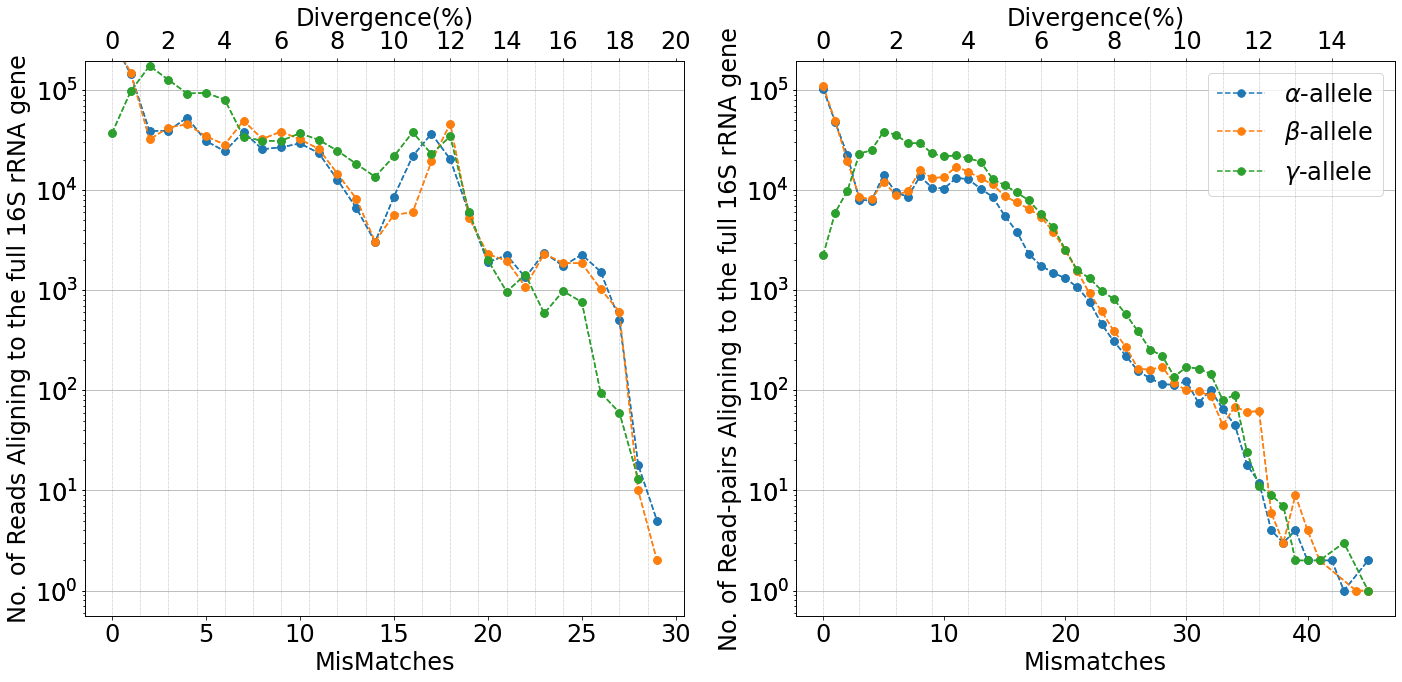

In [5]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Num_Reads', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Num_Reads', color = colors[i], marker = 'o', 
                                              ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], marker = 'o', ms = 7.5, 
                                              ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('No. of Reads Aligning to the full 16S rRNA gene')
ax[1].set_ylabel('No. of Read-pairs Aligning to the full 16S rRNA gene')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[0].set_ylim(ax[1].get_ylim())
ax[0].set_xlim([ax02.get_xlim()[0]*1.5 , ax02.get_xlim()[1]*1.5])
ax[1].set_xlim([ax12.get_xlim()[0]*3 , ax12.get_xlim()[1]*3])

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

ax[0].yaxis.grid()
ax[1].yaxis.grid()

fig.tight_layout()

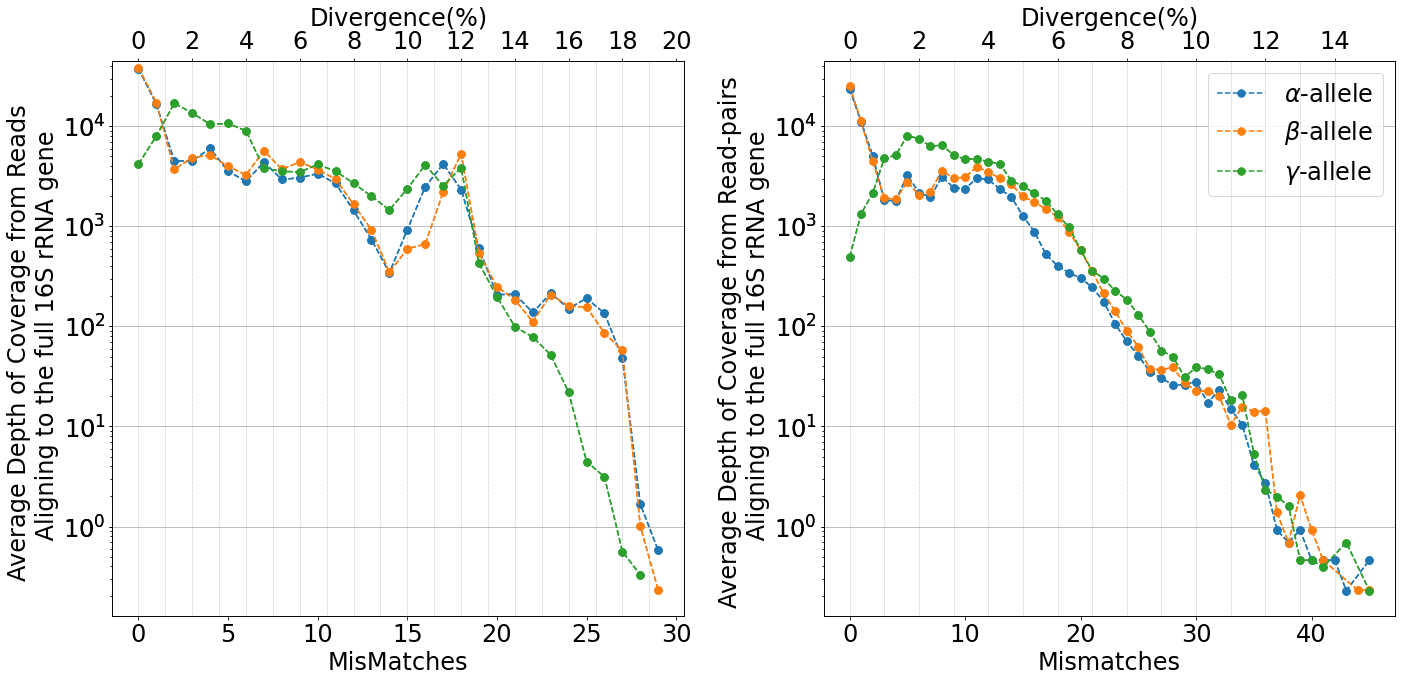

In [6]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Avg_Depth_Coverage', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('Average Depth of Coverage from Reads \n Aligning to the full 16S rRNA gene')
ax[1].set_ylabel('Average Depth of Coverage from Read-pairs \n Aligning to the full 16S rRNA gene')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[0].set_ylim(ax[1].get_ylim())
ax[0].set_xlim([ax02.get_xlim()[0]*1.5 , ax02.get_xlim()[1]*1.5])
ax[1].set_xlim([ax12.get_xlim()[0]*3 , ax12.get_xlim()[1]*3])

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

ax[0].yaxis.grid()
ax[1].yaxis.grid()

fig.tight_layout()

In [7]:
df_all_abundances_grp_sample_full = df_all_abundances.groupby(['Subject','Sample', 
                                                               'MisMatches']).apply(Coverage_Stats,
                                                                                    slen = 1300, length = 1300)
df_all_abundances_grp_sample_full = df_all_abundances_grp_sample_full.reset_index().set_index(['Subject', 
                                                                                               'Sample'])
df_all_abundances_grp_sample_full['Divergence'] = df_all_abundances_grp_sample_full['MisMatches']/150.0*100

df_all_abundances_grp_sample_full_pe = df_paired_end_read_abundances.groupby(['MisMatches_Total',
                                                                              'Subject', 
                                                                              'Sample']).apply(Coverage_Stats,
                                                                                               slen = 1300,
                                                                                               pe = True, 
                                                                                               length = 1300)
df_all_abundances_grp_sample_full_pe = df_all_abundances_grp_sample_full_pe.reset_index().set_index(['Subject', 
                                                                                                     'Sample'])
df_all_abundances_grp_sample_full_pe['Divergence'] = df_all_abundances_grp_sample_full_pe['MisMatches_Total']/300.0*100

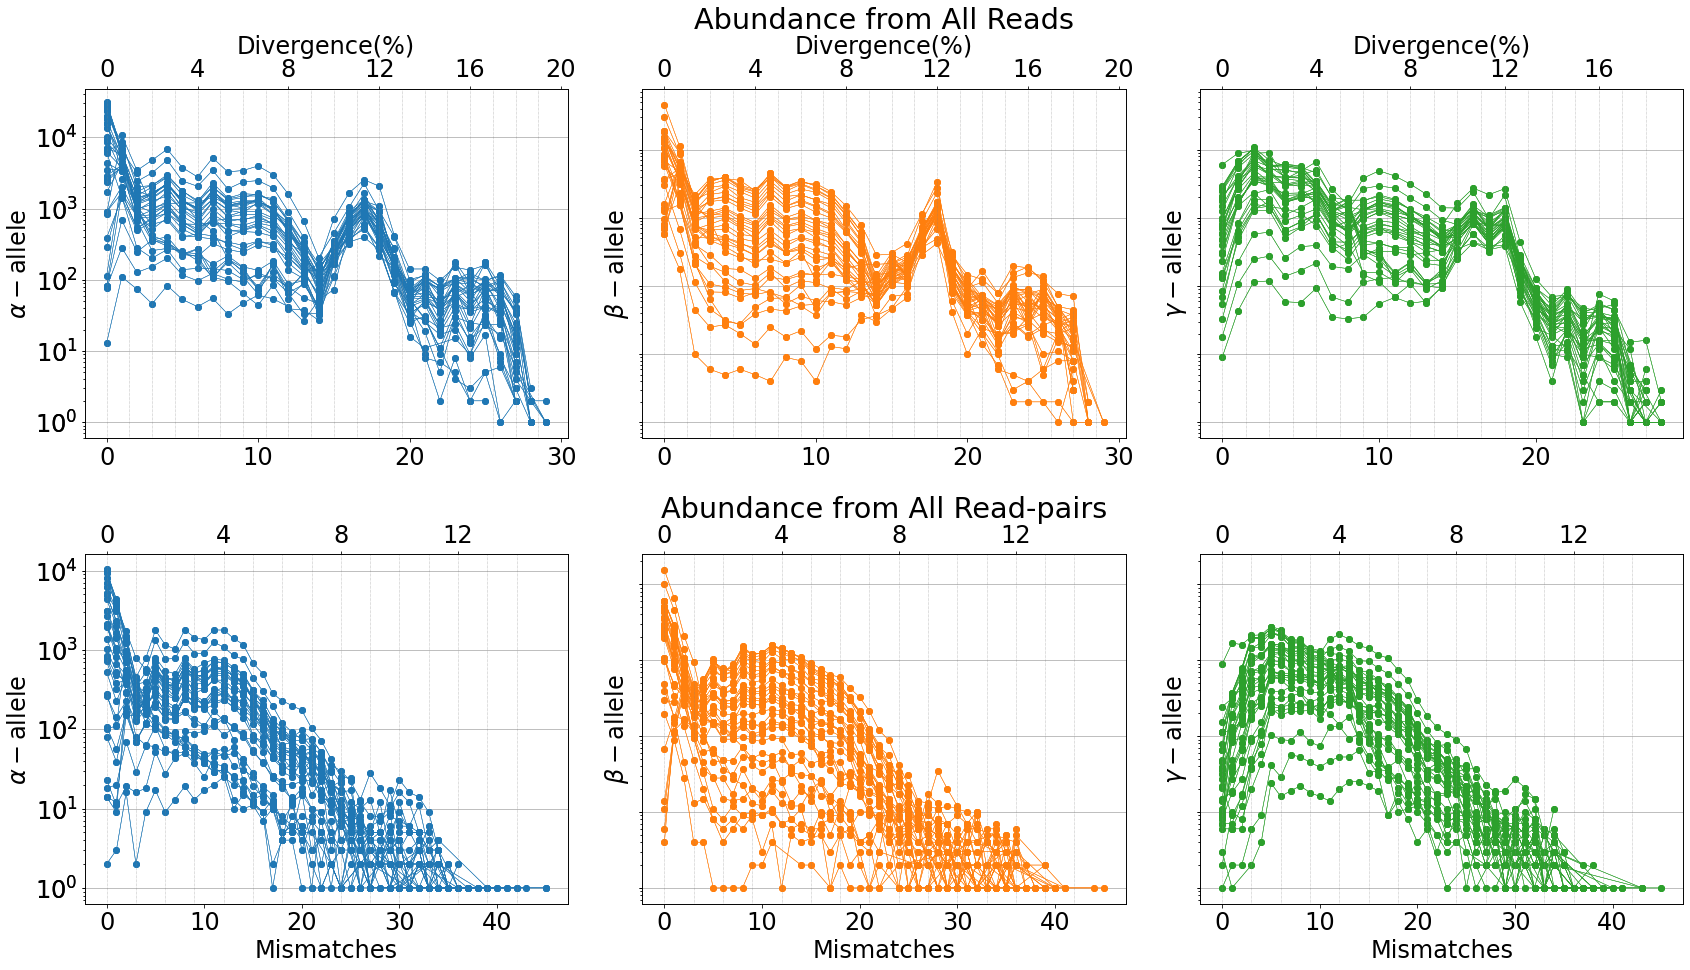

In [8]:
plt.rcParams.update(rcParams)
samples = df_all_abundances_grp_sample_full.reset_index()['Sample'].unique()
fig, ax = plt.subplots(2,3, figsize = (24, 14))
ax0_twinx = [ax[0][0].twiny(), ax[0][1].twiny(), ax[0][2].twiny()]
ax1_twinx = [ax[1][0].twiny(), ax[1][1].twiny(), ax[1][2].twiny()]
ylabels = [r'$\alpha-$allele',r'$\beta-$allele',r'$\gamma-$allele']
for s in samples:
    for i in range(0, len(colors)):
        df_all_abundances_grp_sample_full.loc[(species[i],s)].plot('MisMatches', 'Num_Reads', marker = 'o', 
                                                                   ax = ax[0][i], color = colors[i],
                                                                   legend = False, linewidth = 0.5)
        df_all_abundances_grp_sample_full.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', 
                                                                   ax = ax0_twinx[i], color = colors[i], 
                                                                   legend = False, linewidth = 0.5)
        
        df_all_abundances_grp_sample_full_pe.loc[(species[i],s)].plot('MisMatches_Total','Num_Reads',marker = 'o', 
                                                                      ax = ax[1][i], color = colors[i],
                                                                      legend = False, linewidth = 0.5) 
        df_all_abundances_grp_sample_full_pe.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', 
                                                                      ax = ax1_twinx[i], color = colors[i],
                                                                      legend = False, linewidth = 0.5) 
for j in range(0, len(species)):
    for i in range(0, int(ax0_twinx[j].get_xlim()[1])):
        ax0_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax0_twinx[j].set_xticks(np.arange(0,int(ax0_twinx[j].get_xlim()[1])+1,4))
    ax0_twinx[j].set_xlabel('Divergence(%)')
    ax[0][j].set_xlabel('')
    ax[0][j].set_yscale('log')
    ax[0][j].set_ylim(ax[0][1].get_ylim())
    ax[0][j].set_ylabel(ylabels[j])
    ax[0][j].yaxis.grid() 

    for i in range(0, int(ax1_twinx[j].get_xlim()[1])):
        ax1_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax1_twinx[j].set_xticks(np.arange(0,int(ax1_twinx[j].get_xlim()[1])+1,4))
    ax1_twinx[j].set_xlabel('')
    ax[1][j].set_xlabel('Mismatches')
    ax[1][j].set_yscale('log')
    ax[1][j].set_ylim(ax[1][1].get_ylim())
    ax[1][j].set_ylabel(ylabels[j])
    ax[1][j].yaxis.grid() 

    if j != 0:
        ax[0][j].set_yticklabels([])
        ax[1][j].set_yticklabels([])
        
ax[0][1].set_title('Abundance from All Reads')
ax[1][1].set_title('Abundance from All Read-pairs')

fig.tight_layout()

In [9]:
df_all_abundances_filt = df_all_abundances.loc[(df_all_abundances['SStart'] >= 100) & 
                                               (df_all_abundances['SEnd'] <= 450) ]
df_abundances_grp = df_all_abundances_filt.groupby(['Subject','MisMatches']).apply(Coverage_Stats, slen = 450, 
                                                                                   pe = False, length = 350)
df_abundances_grp = df_abundances_grp.reset_index().set_index('Subject')
df_abundances_grp['Divergence'] = df_abundances_grp['MisMatches']/150.0*100

df_pe_abundances_filt = df_paired_end_read_abundances.loc[(df_paired_end_read_abundances[('SStart','1')] >= 100) &
                                                          (df_paired_end_read_abundances[('SStart','2')] >= 100) &
                                                          (df_paired_end_read_abundances[('SEnd','1')] <= 450) &
                                                          (df_paired_end_read_abundances[('SEnd','2')] <= 450)]
df_abundances_grp_pe = df_pe_abundances_filt.groupby(['MisMatches_Total','Subject']).apply(Coverage_Stats, 
                                                                                           slen = 450, pe = True,
                                                                                           length = 350)
df_abundances_grp_pe = df_abundances_grp_pe.reset_index().set_index(['Subject'])
df_abundances_grp_pe['Divergence'] = df_abundances_grp_pe['MisMatches_Total']/300.0*100

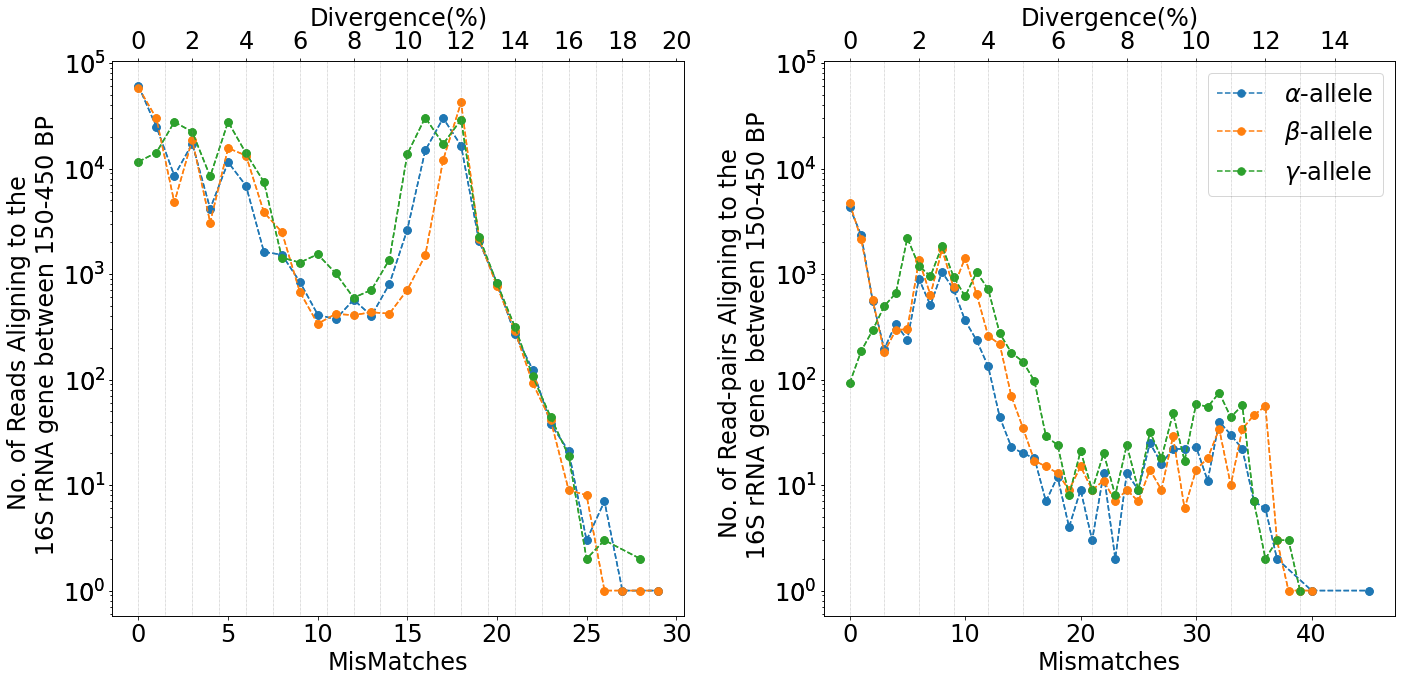

In [10]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Num_Reads', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Num_Reads', color = colors[i], marker = 'o', 
                                              ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], marker = 'o', ms = 7.5, 
                                              ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('No. of Reads Aligning to the \n 16S rRNA gene between 150-450 BP')
ax[1].set_ylabel('No. of Read-pairs Aligning to the \n 16S rRNA gene  between 150-450 BP')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

fig.tight_layout()

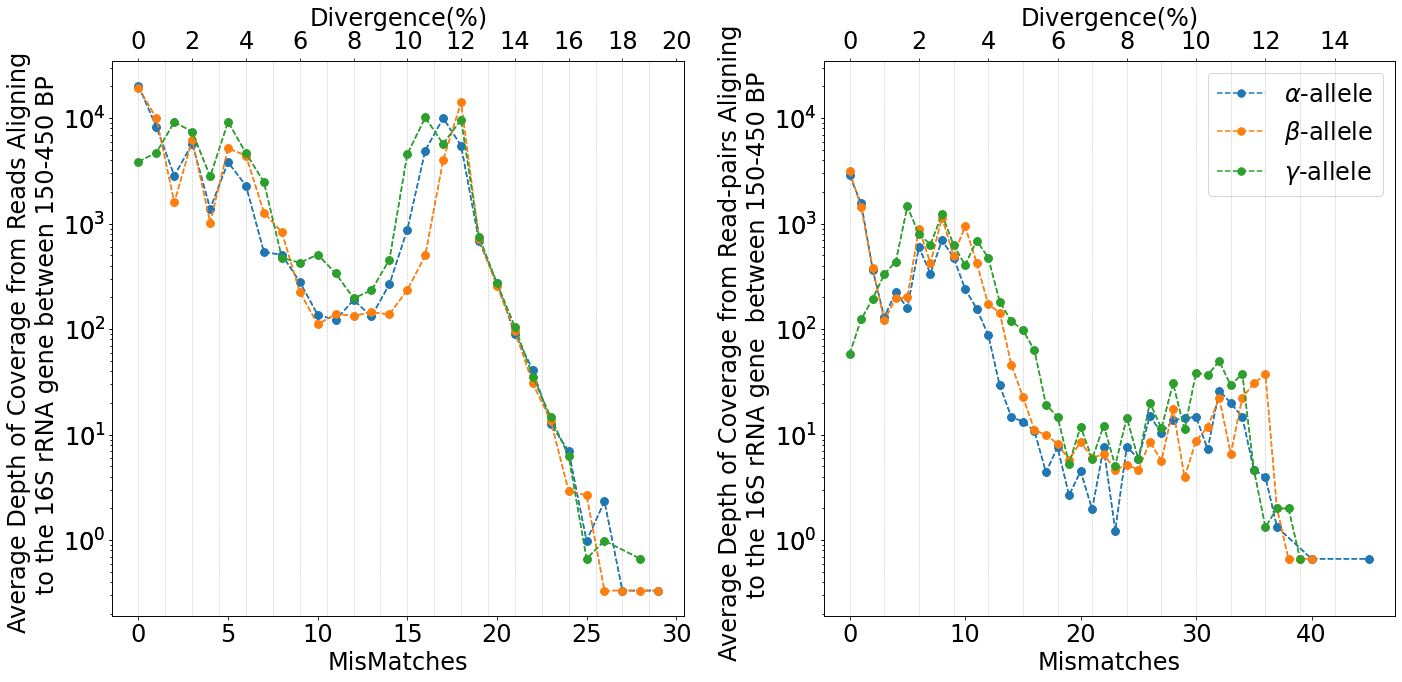

In [11]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Avg_Depth_Coverage', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('Average Depth of Coverage from Reads Aligning \n to the 16S rRNA gene between 150-450 BP')
ax[1].set_ylabel('Average Depth of Coverage from Read-pairs Aligning \n to the 16S rRNA gene  between 150-450 BP')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

fig.tight_layout()

In [12]:
df_all_abundances_filt = df_all_abundances.loc[df_all_abundances['SEnd'] < 1300]
df_all_abundances_filt = df_all_abundances_filt.set_index('Subject')
alleles = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
op = {}
for c in alleles:
    mismatches = np.zeros(1300)
    coverage = np.zeros(1300)
    num_reads = np.zeros(1300)
    
    CS_String = df_all_abundances_filt.loc[c]['CS'].tolist()
    SStart = df_all_abundances_filt.loc[c]['SStart'].tolist()
    SEnd = df_all_abundances_filt.loc[c]['SEnd'].tolist()
    Orientation = df_all_abundances_filt.loc[c]['Orientation'].tolist()
    
    for i in range(0, len(CS_String)):
        V1 = Process_CS_String(CS_String[i], SEnd[i]-SStart[i])
        if Orientation[i] == '+': mismatches[SStart[i]:SEnd[i]] += V1
        elif Orientation[i] == '-': mismatches[SStart[i]:SEnd[i]] += V1[::-1]
        coverage[SStart[i]:SEnd[i]] += 1
        num_reads[SEnd[i]] += 1
    
    op[c] = {'Mismatches':mismatches, 'Coverage':coverage, 'Num_Reads':num_reads}
    print(c)

Synechococcus_Alpha_16SrRNA
Synechococcus_Beta_16SrRNA
Synechococcus_Gamma_16SrRNA


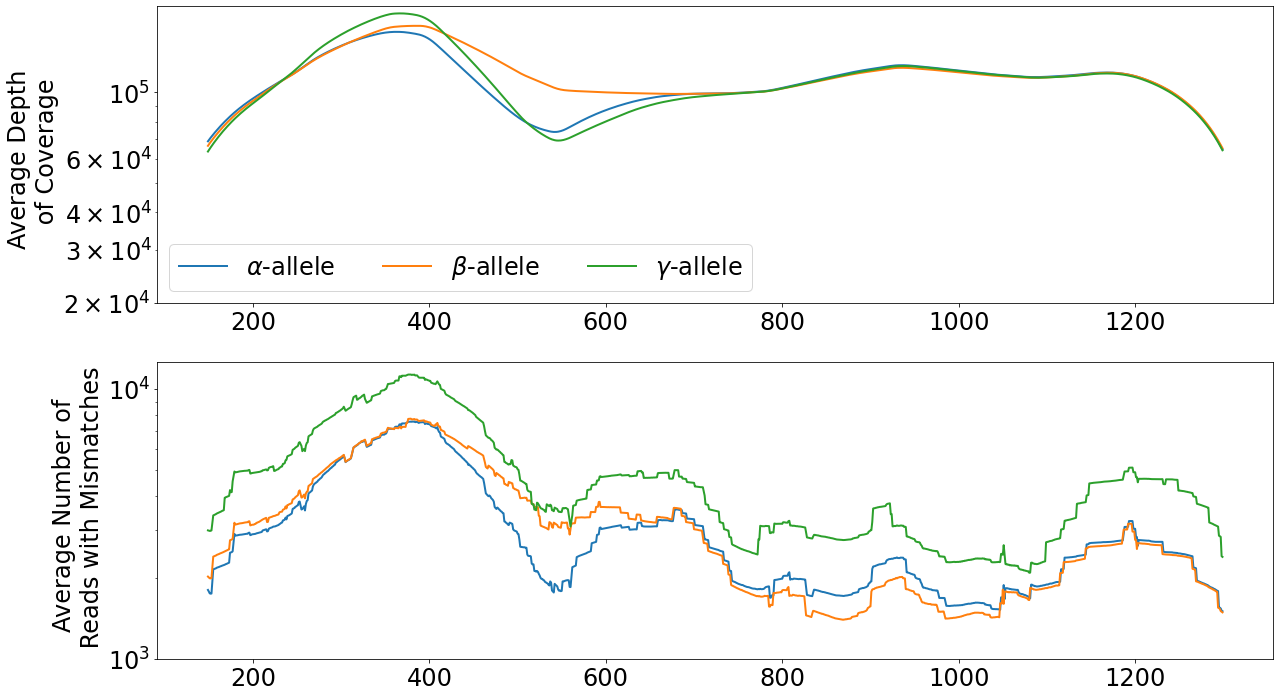

In [13]:
fig, ax = plt.subplots(2,1,figsize = (20,12))
ax[0].plot(pd.Series(op[alleles[0]]['Coverage']).rolling(window = 150).mean(), color = 'C0', 
           label = r'$\alpha$-allele', linewidth = 2)
ax[0].plot(pd.Series(op[alleles[1]]['Coverage']).rolling(window = 150).mean(), color = 'C1', 
           label = r'$\beta$-allele', linewidth = 2)
ax[0].plot(pd.Series(op[alleles[2]]['Coverage']).rolling(window = 150).mean(), color = 'C2', 
           label = r'$\gamma$-allele', linewidth = 2)

ax[1].plot(pd.Series(op[alleles[0]]['Mismatches']).rolling(window = 150).mean(), color = 'C0', linewidth = 2)
ax[1].plot(pd.Series(op[alleles[1]]['Mismatches']).rolling(window = 150).mean(), color = 'C1', linewidth = 2)
ax[1].plot(pd.Series(op[alleles[2]]['Mismatches']).rolling(window = 150).mean(), color = 'C2', linewidth = 2)

ax[0].legend(ncol = 3)
ax[0].set_ylabel('Average Depth \n of Coverage')
ax[1].set_ylabel('Average Number of \n Reads with Mismatches')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_yticks([20000, 100000])
ax[1].set_yticks([1000, 10000])


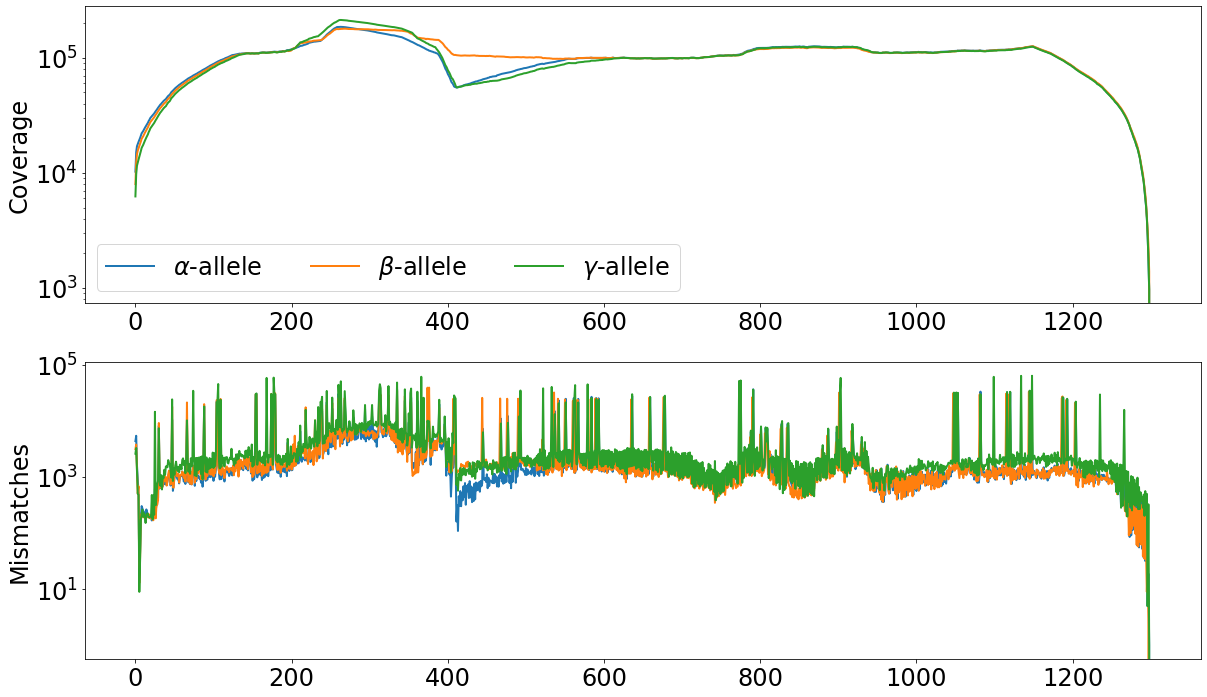

In [14]:
fig, ax = plt.subplots(2,1,figsize = (20,12))
ax[0].plot(op[alleles[0]]['Coverage'], color = 'C0', label = r'$\alpha$-allele', linewidth = 2)
ax[0].plot(op[alleles[1]]['Coverage'], color = 'C1', label = r'$\beta$-allele', linewidth = 2)
ax[0].plot(op[alleles[2]]['Coverage'], color = 'C2', label = r'$\gamma$-allele', linewidth = 2)

ax[1].plot(op[alleles[0]]['Mismatches'], color = 'C0', linewidth = 2)
ax[1].plot(op[alleles[1]]['Mismatches'], color = 'C1', linewidth = 2)
ax[1].plot(op[alleles[2]]['Mismatches'], color = 'C2', linewidth = 2)

ax[0].legend(loc = 3, ncol = 3)
ax[0].set_ylabel('Coverage')
ax[1].set_ylabel('Mismatches')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

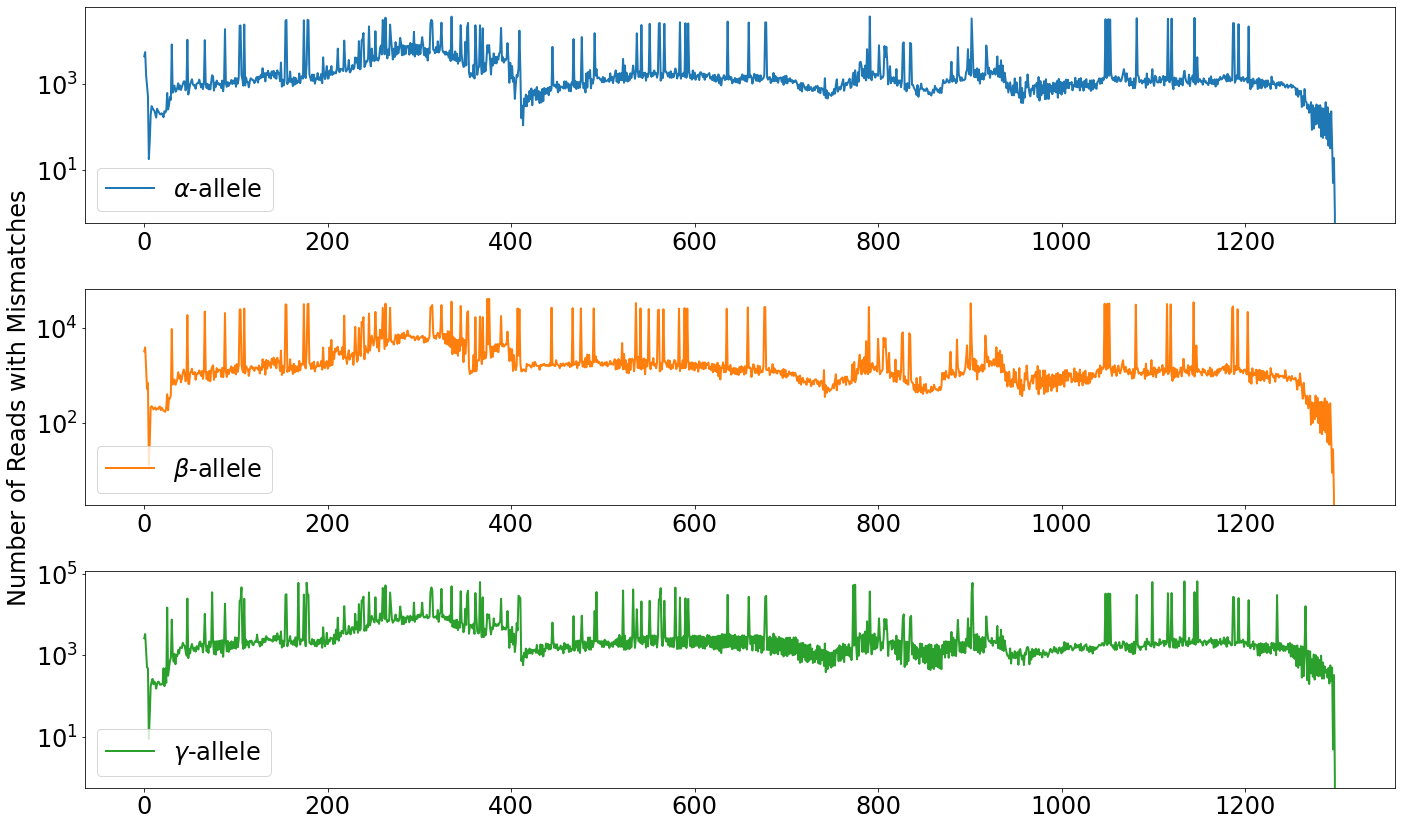

In [15]:
fig, ax = plt.subplots(3,1,figsize = (20,12))

ax[0].plot(op[alleles[0]]['Mismatches'], color = 'C0', linewidth = 2, label = r'$\alpha$-allele')
ax[1].plot(op[alleles[1]]['Mismatches'], color = 'C1', linewidth = 2, label = r'$\beta$-allele')
ax[2].plot(op[alleles[2]]['Mismatches'], color = 'C2', linewidth = 2, label = r'$\gamma$-allele')

ax[0].legend(loc = 3, ncol = 3)
ax[1].legend(loc = 3, ncol = 3)
ax[2].legend(loc = 3, ncol = 3)

ax[1].set_ylabel('Number of Reads with Mismatches')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
fig.tight_layout()


In [16]:
samples_of_interest = ['HotsprSampleMS50','HotsprSampleMS55','HotsprSampleMS60','HotsprSampleMS65']
df_MS_all_reads = df_all_abundances[df_all_abundances['Sample'].isin(samples_of_interest)]
df_MS_PE_reads = df_paired_end_read_abundances[df_paired_end_read_abundances['Sample'].isin(samples_of_interest)]

In [17]:
df_abundances_grp = df_MS_all_reads.groupby(['Subject','MisMatches']).apply(Coverage_Stats, slen = 1300, 
                                                                            pe = False, length = 1300)
df_abundances_grp = df_abundances_grp.reset_index().set_index('Subject')
df_abundances_grp['Divergence'] = df_abundances_grp['MisMatches']/150.0*100

df_abundances_grp_pe = df_MS_PE_reads.groupby(['MisMatches_Total','Subject']).apply(Coverage_Stats, slen = 1300, 
                                                                                    pe = True, length = 1300)
df_abundances_grp_pe = df_abundances_grp_pe.reset_index().set_index(['Subject'])
df_abundances_grp_pe['Divergence'] = df_abundances_grp_pe['MisMatches_Total']/300.0*100

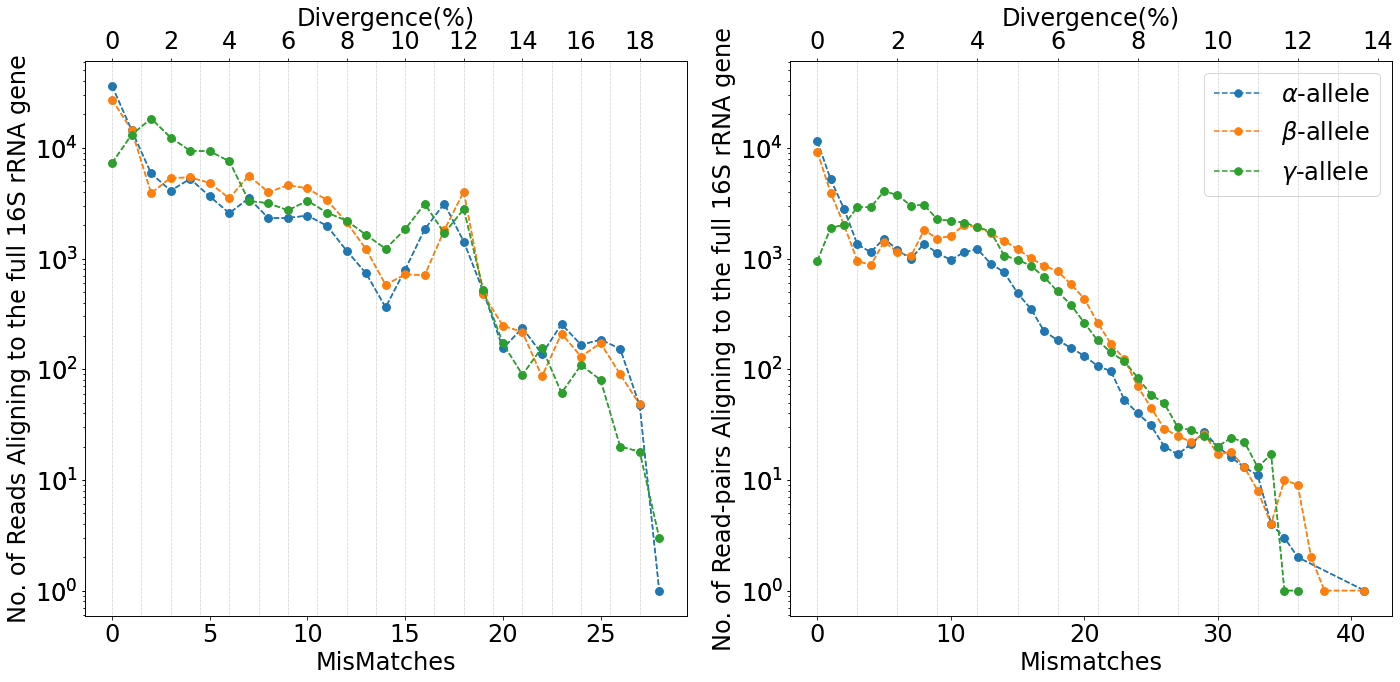

In [18]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Num_Reads', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Num_Reads', color = colors[i], marker = 'o', 
                                              ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], marker = 'o', ms = 7.5, 
                                              ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('No. of Reads Aligning to the full 16S rRNA gene')
ax[1].set_ylabel('No. of Read-pairs Aligning to the full 16S rRNA gene')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

fig.tight_layout()

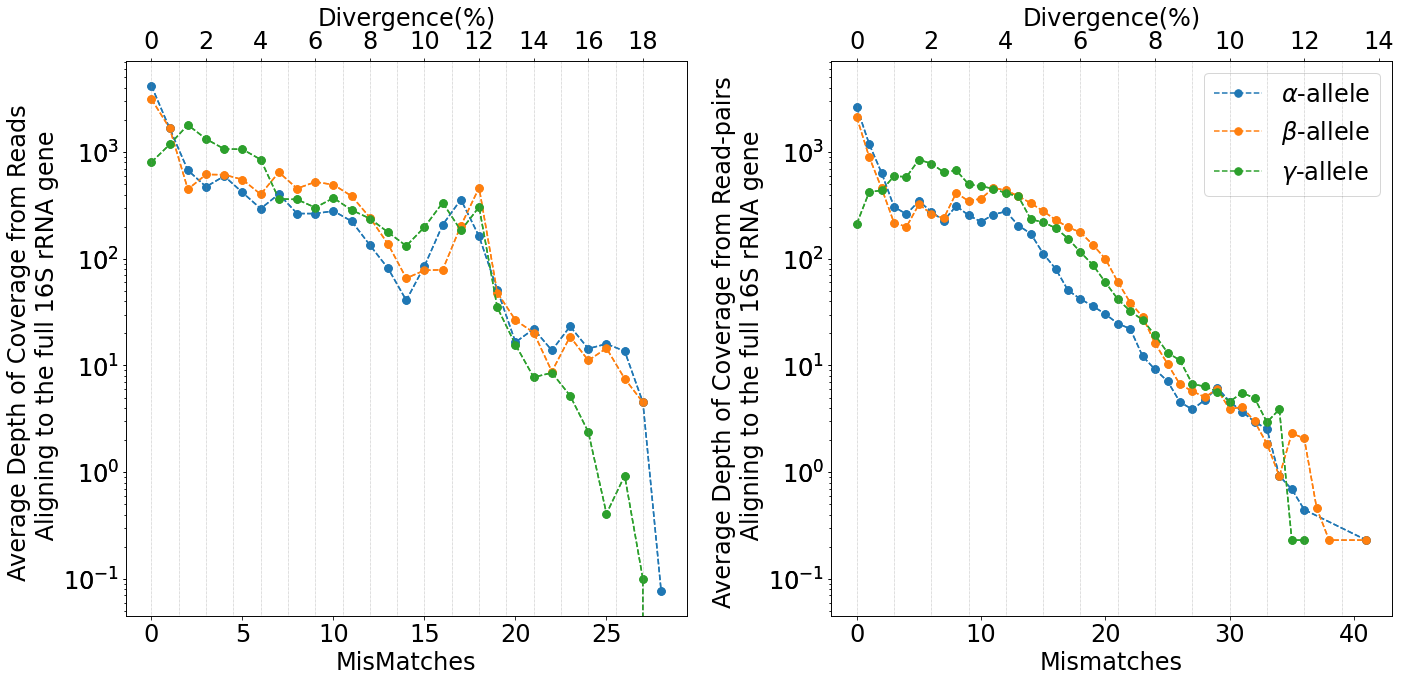

In [19]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Avg_Depth_Coverage', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('Average Depth of Coverage from Reads \n Aligning to the full 16S rRNA gene')
ax[1].set_ylabel('Average Depth of Coverage from Read-pairs \n Aligning to the full 16S rRNA gene')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

fig.tight_layout()

In [20]:
df_all_abundances_grp_sample_full = df_MS_all_reads.groupby(['Subject','Sample',
                                                             'MisMatches']).apply(Coverage_Stats,slen = 1300,
                                                                                 length = 1300)
df_all_abundances_grp_sample_full = df_all_abundances_grp_sample_full.reset_index().set_index(['Subject', 
                                                                                               'Sample'])
df_all_abundances_grp_sample_full['Divergence'] = df_all_abundances_grp_sample_full['MisMatches']/150.0*100

df_all_abundances_grp_sample_full_pe = df_MS_PE_reads.groupby(['MisMatches_Total','Subject', 
                                                               'Sample']).apply(Coverage_Stats,slen = 1300,
                                                                                pe = True, length = 1300)
df_all_abundances_grp_sample_full_pe = df_all_abundances_grp_sample_full_pe.reset_index().set_index(['Subject', 
                                                                                                     'Sample'])
df_all_abundances_grp_sample_full_pe['Divergence'] = df_all_abundances_grp_sample_full_pe['MisMatches_Total']/300.0*100

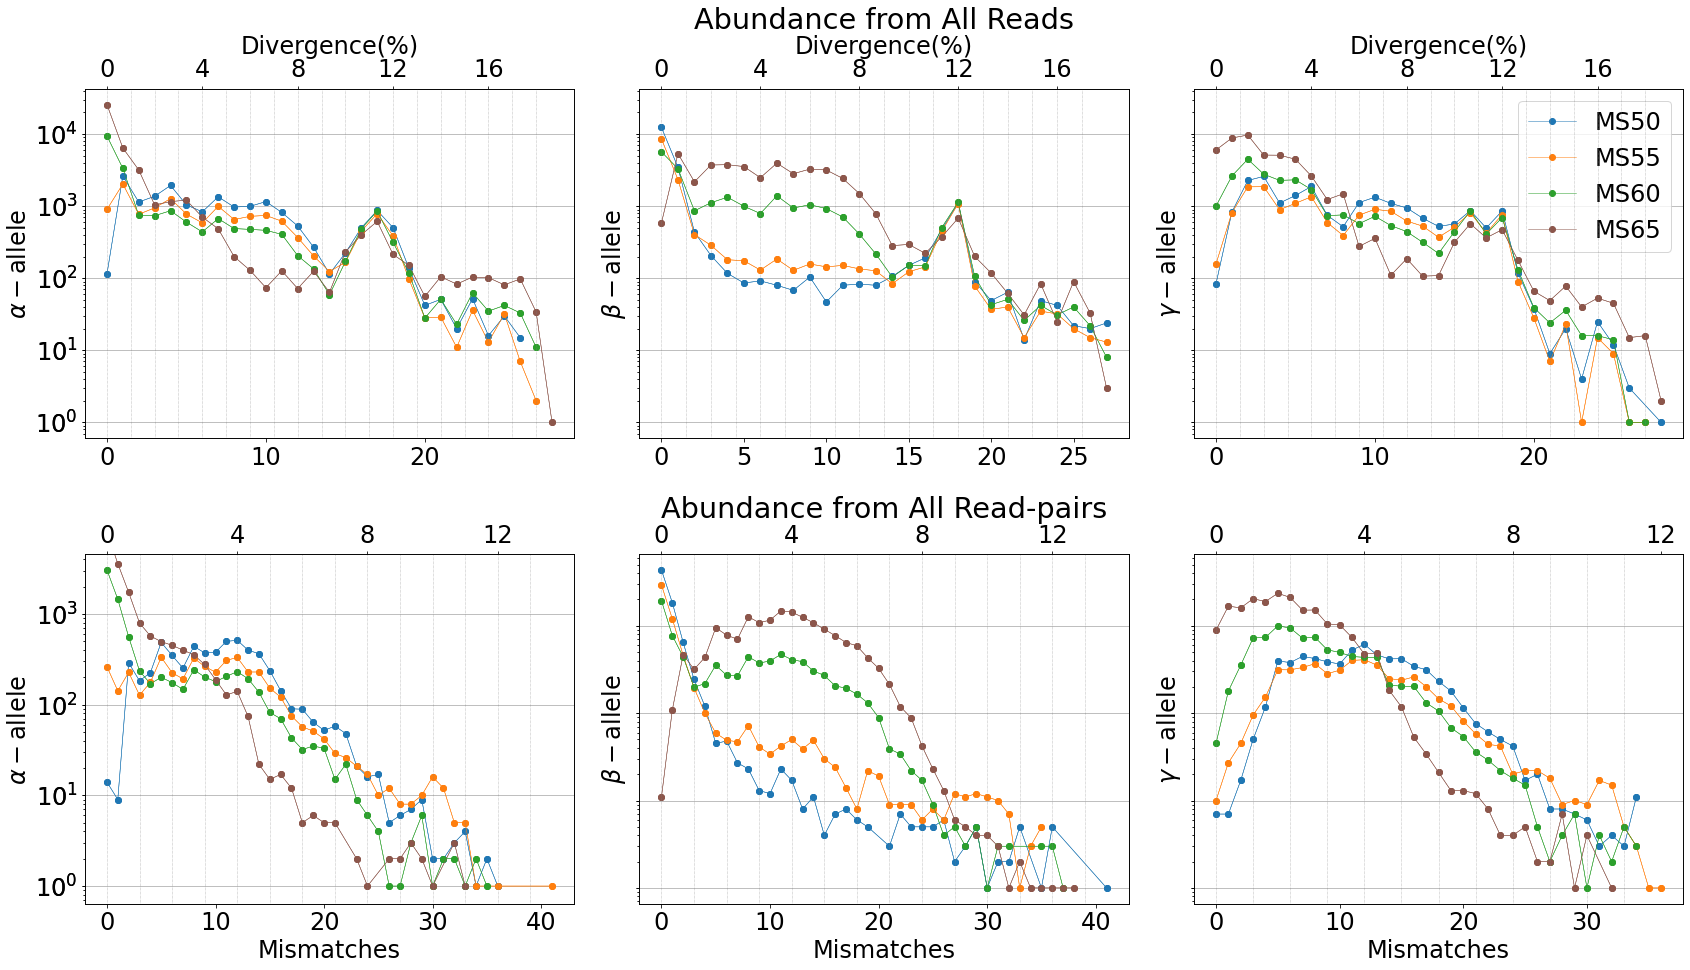

In [21]:
plt.rcParams.update(rcParams)
colors = ['C0','C1','C2','C5']

samples = df_all_abundances_grp_sample_full.reset_index()['Sample'].unique()
fig, ax = plt.subplots(2,3, figsize = (24, 14))
ax0_twinx = [ax[0][0].twiny(), ax[0][1].twiny(), ax[0][2].twiny()]
ax1_twinx = [ax[1][0].twiny(), ax[1][1].twiny(), ax[1][2].twiny()]
ylabels = [r'$\alpha-$allele',r'$\beta-$allele',r'$\gamma-$allele']
for j in range(0, len(samples_of_interest)):
    for i in range(0, len(species)):
        s = samples_of_interest[j]
        df_all_abundances_grp_sample_full.loc[(species[i],s)].plot('MisMatches', 'Num_Reads', marker = 'o', 
                                                                   ax = ax[0][i], color = colors[j],
                                                                   legend = False, linewidth = 0.5)
        df_all_abundances_grp_sample_full.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', 
                                                                   ax = ax0_twinx[i], color = colors[j], 
                                                                   legend = False, linewidth = 0.5)
        
        df_all_abundances_grp_sample_full_pe.loc[(species[i],s)].plot('MisMatches_Total','Num_Reads',marker = 'o', 
                                                                      ax = ax[1][i], color = colors[j],
                                                                      legend = False, linewidth = 0.5) 
        df_all_abundances_grp_sample_full_pe.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', 
                                                                      ax = ax1_twinx[i], color = colors[j],
                                                                      legend = False, linewidth = 0.5) 
ax[0][2].legend(['MS50','MS55','MS60','MS65'])

for j in range(0, len(species)):
    for i in range(0, int(ax0_twinx[j].get_xlim()[1])):
        ax0_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax0_twinx[j].set_xticks(np.arange(0,int(ax0_twinx[j].get_xlim()[1])+1,4))
    ax0_twinx[j].set_xlabel('Divergence(%)')
    ax[0][j].set_xlabel('')
    ax[0][j].set_yscale('log')
    ax[0][j].set_ylim(ax[0][0].get_ylim())
    ax[0][j].set_ylabel(ylabels[j])
    ax[0][j].yaxis.grid() 

    for i in range(0, int(ax1_twinx[j].get_xlim()[1])):
        ax1_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax1_twinx[j].set_xticks(np.arange(0,int(ax1_twinx[j].get_xlim()[1])+1,4))
    ax1_twinx[j].set_xlabel('')
    ax[1][j].set_xlabel('Mismatches')
    ax[1][j].set_yscale('log')
    ax[1][j].set_ylim(ax[1][1].get_ylim())
    ax[1][j].set_ylabel(ylabels[j])
    ax[1][j].yaxis.grid() 

    if j != 0:
        ax[0][j].set_yticklabels([])
        ax[1][j].set_yticklabels([])
        
ax[0][1].set_title('Abundance from All Reads')
ax[1][1].set_title('Abundance from All Read-pairs')

fig.tight_layout()

In [22]:
df_all_abundances_filt = df_MS_all_reads.loc[(df_MS_all_reads['SStart'] >= 100) & 
                                             (df_MS_all_reads['SEnd'] <= 450) ]
df_abundances_grp = df_all_abundances_filt.groupby(['Subject','MisMatches']).apply(Coverage_Stats, slen = 450, 
                                                                                   pe = False, length = 350)
df_abundances_grp = df_abundances_grp.reset_index().set_index('Subject')
df_abundances_grp['Divergence'] = df_abundances_grp['MisMatches']/150.0*100

df_pe_abundances_filt = df_MS_PE_reads.loc[(df_MS_PE_reads[('SStart','1')] >= 100) & 
                                           (df_MS_PE_reads[('SStart','2')] >= 100) &
                                           (df_MS_PE_reads[('SEnd','1')] <= 450) &
                                           (df_MS_PE_reads[('SEnd','2')] <= 450)]
df_abundances_grp_pe = df_pe_abundances_filt.groupby(['MisMatches_Total','Subject']).apply(Coverage_Stats, 
                                                                                           slen = 450, pe = True,
                                                                                          length = 350)
df_abundances_grp_pe = df_abundances_grp_pe.reset_index().set_index(['Subject'])
df_abundances_grp_pe['Divergence'] = df_abundances_grp_pe['MisMatches_Total']/300.0*100

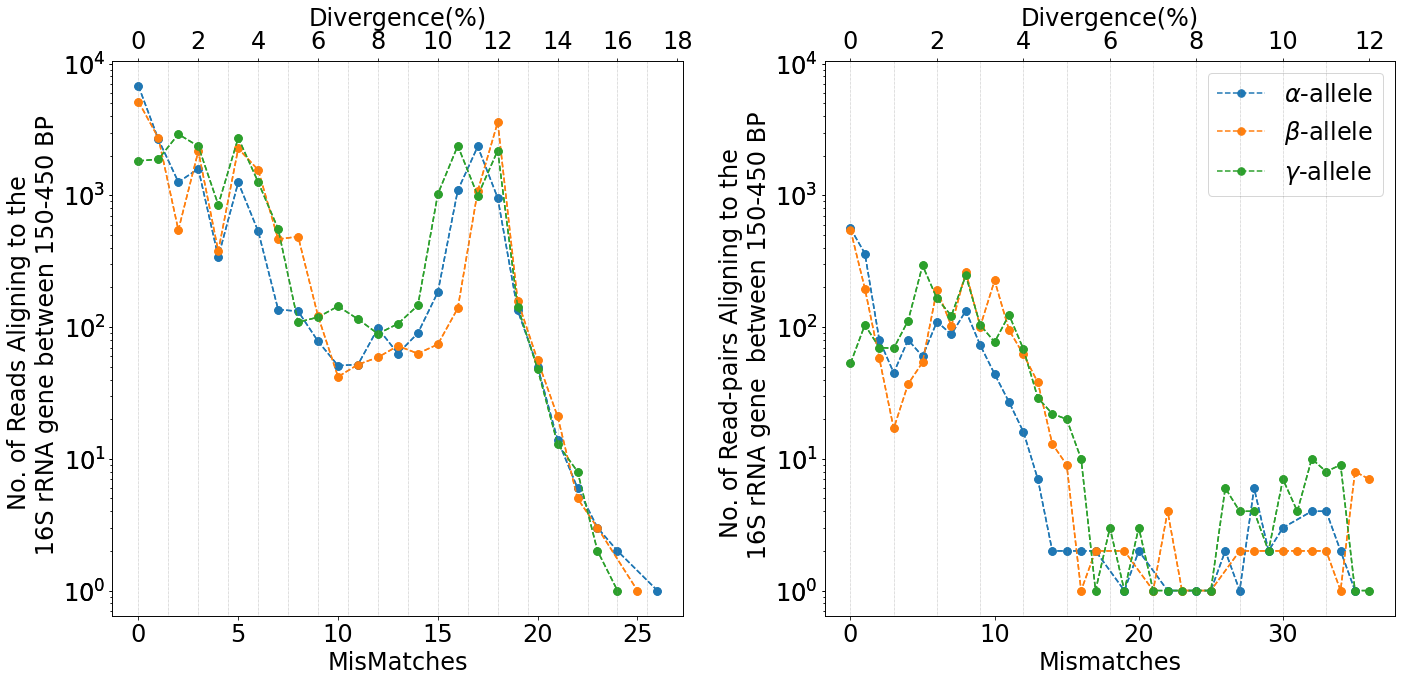

In [23]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Num_Reads', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Num_Reads', color = colors[i], marker = 'o', 
                                              ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], marker = 'o', ms = 7.5, 
                                              ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('No. of Reads Aligning to the \n 16S rRNA gene between 150-450 BP')
ax[1].set_ylabel('No. of Read-pairs Aligning to the \n 16S rRNA gene  between 150-450 BP')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

fig.tight_layout()

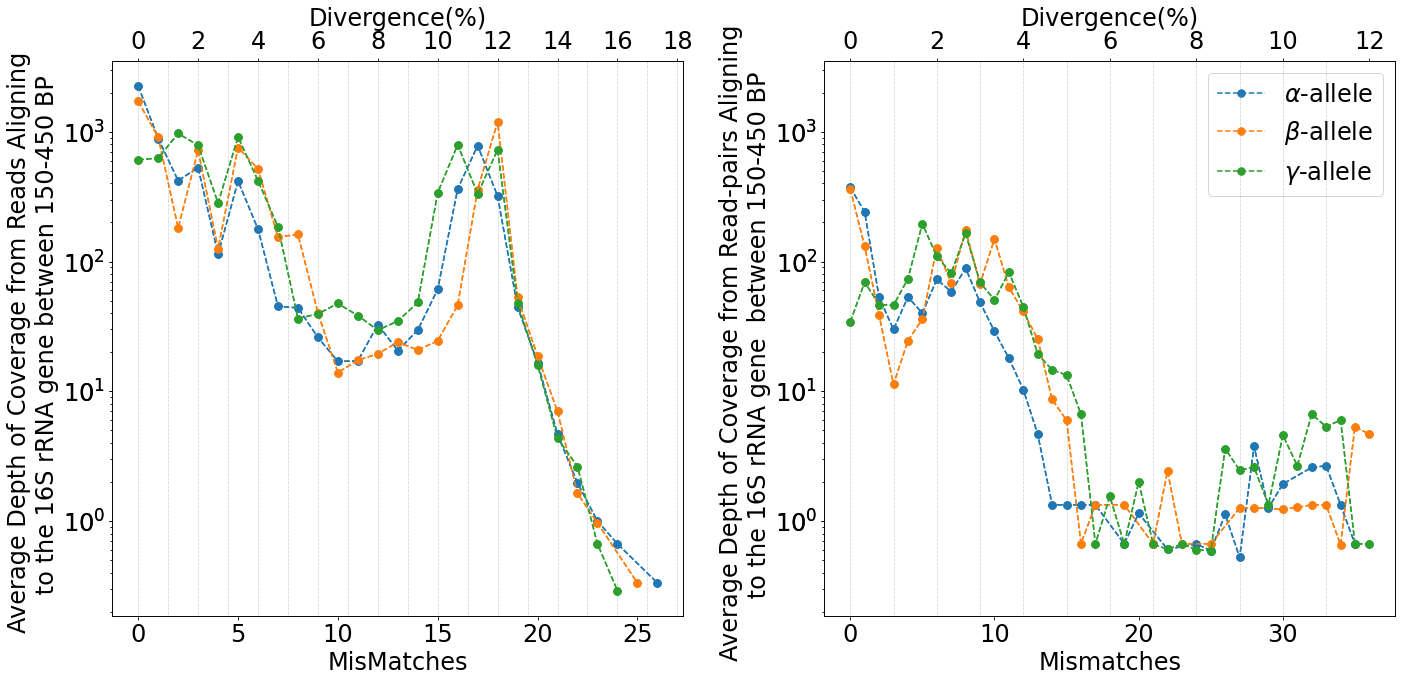

In [24]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_abundances_grp.loc[species[i]].plot('MisMatches','Avg_Depth_Coverage', color = colors[i], marker = 'o', 
                                           ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_abundances_grp.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], legend = False, 
                                           marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('MisMatches_Total','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax[1], linestyle = '--')
    df_abundances_grp_pe.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], 
                                              marker = 'o', ms = 7.5, ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('Average Depth of Coverage from Reads Aligning \n to the 16S rRNA gene between 150-450 BP')
ax[1].set_ylabel('Average Depth of Coverage from Read-pairs Aligning \n to the 16S rRNA gene  between 150-450 BP')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])+1):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

fig.tight_layout()

In [25]:
df_all_abundances_grp_sample_full = df_all_abundances_filt.groupby(['Subject','Sample',
                                                             'MisMatches']).apply(Coverage_Stats,slen = 1300,
                                                                                  length = 250)
df_all_abundances_grp_sample_full = df_all_abundances_grp_sample_full.reset_index().set_index(['Subject', 
                                                                                               'Sample'])
df_all_abundances_grp_sample_full['Divergence'] = df_all_abundances_grp_sample_full['MisMatches']/150.0*100

df_all_abundances_grp_sample_full_pe = df_pe_abundances_filt.groupby(['MisMatches_Total','Subject', 
                                                               'Sample']).apply(Coverage_Stats,slen = 1300,
                                                                                pe = True, length = 350)
df_all_abundances_grp_sample_full_pe = df_all_abundances_grp_sample_full_pe.reset_index().set_index(['Subject', 
                                                                                                     'Sample'])
df_all_abundances_grp_sample_full_pe['Divergence'] = df_all_abundances_grp_sample_full_pe['MisMatches_Total']/300.0*100

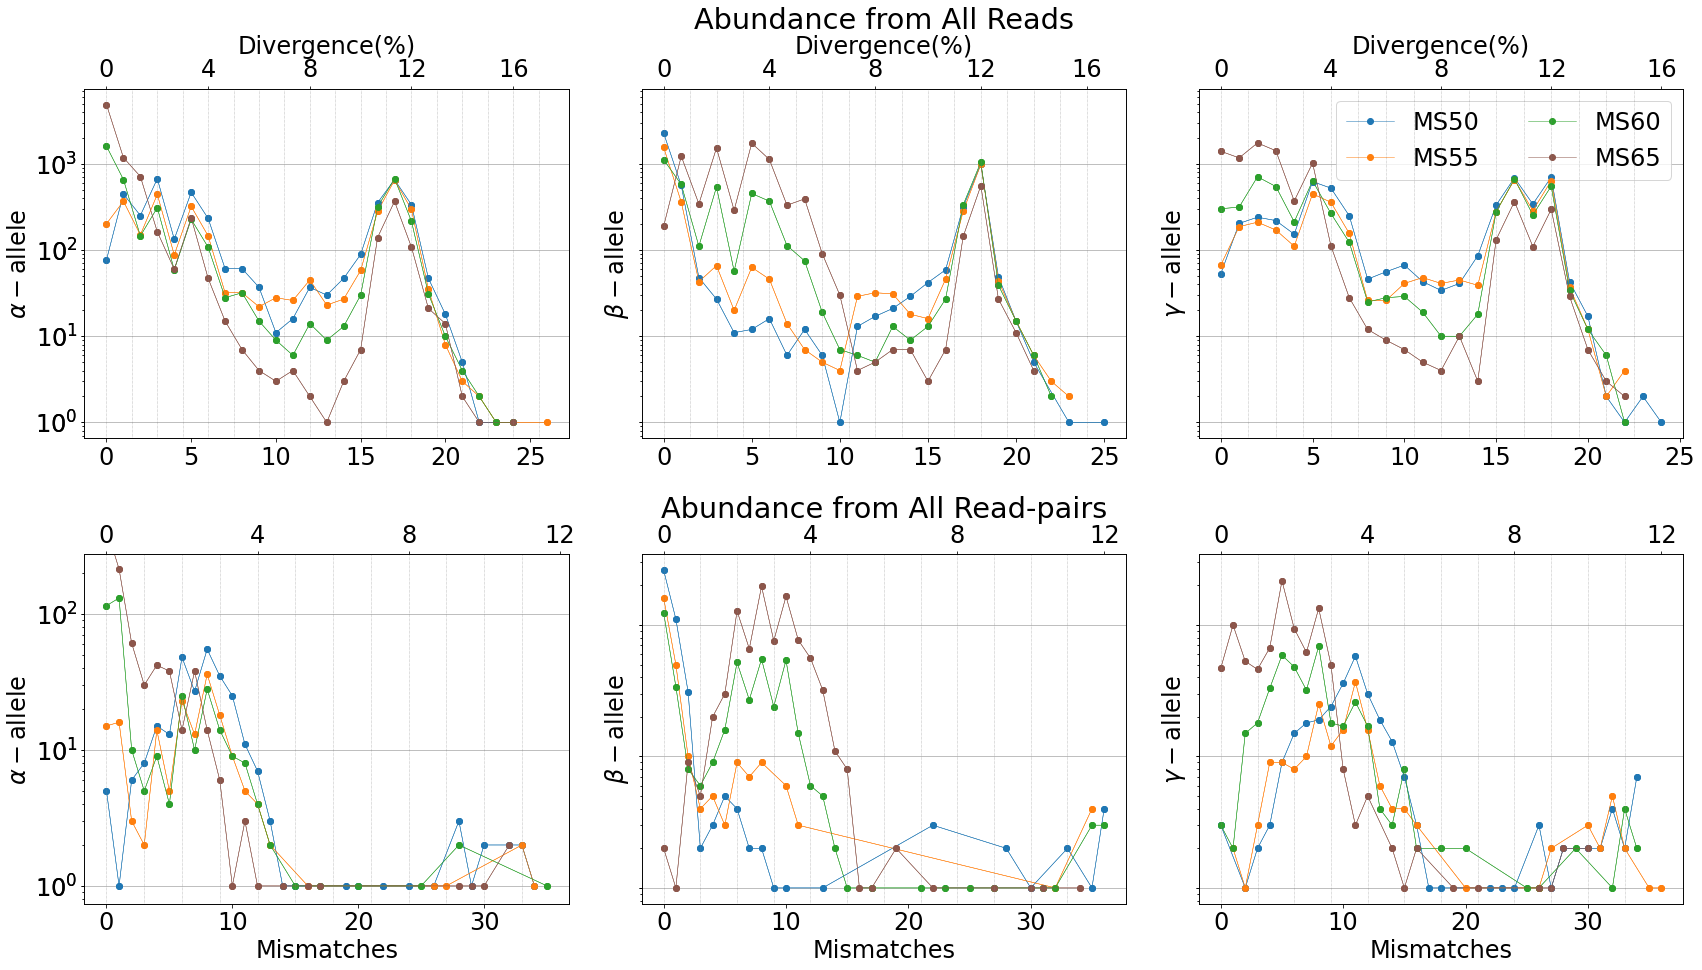

In [26]:
plt.rcParams.update(rcParams)
colors = ['C0','C1','C2','C5']

samples = df_all_abundances_grp_sample_full.reset_index()['Sample'].unique()
fig, ax = plt.subplots(2,3, figsize = (24, 14))
ax0_twinx = [ax[0][0].twiny(), ax[0][1].twiny(), ax[0][2].twiny()]
ax1_twinx = [ax[1][0].twiny(), ax[1][1].twiny(), ax[1][2].twiny()]
ylabels = [r'$\alpha-$allele',r'$\beta-$allele',r'$\gamma-$allele']
for j in range(0, len(samples_of_interest)):
    for i in range(0, len(species)):
        s = samples_of_interest[j]
        df_all_abundances_grp_sample_full.loc[(species[i],s)].plot('MisMatches', 'Num_Reads', marker = 'o', 
                                                                   ax = ax[0][i], color = colors[j],
                                                                   legend = False, linewidth = 0.5)
        df_all_abundances_grp_sample_full.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', 
                                                                   ax = ax0_twinx[i], color = colors[j], 
                                                                   legend = False, linewidth = 0.5)
        
        df_all_abundances_grp_sample_full_pe.loc[(species[i],s)].plot('MisMatches_Total','Num_Reads',marker = 'o', 
                                                                      ax = ax[1][i], color = colors[j],
                                                                      legend = False, linewidth = 0.5) 
        df_all_abundances_grp_sample_full_pe.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', 
                                                                      ax = ax1_twinx[i], color = colors[j],
                                                                      legend = False, linewidth = 0.5) 
ax[0][2].legend(['MS50','MS55','MS60','MS65'], loc = 1, ncol = 2)

for j in range(0, len(species)):
    for i in range(0, int(ax0_twinx[j].get_xlim()[1])):
        ax0_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax0_twinx[j].set_xticks(np.arange(0,int(ax0_twinx[j].get_xlim()[1])+1,4))
    ax0_twinx[j].set_xlabel('Divergence(%)')
    ax[0][j].set_xlabel('')
    ax[0][j].set_yscale('log')
    ax[0][j].set_ylim(ax[0][0].get_ylim())
    ax[0][j].set_ylabel(ylabels[j])
    ax[0][j].yaxis.grid() 

    for i in range(0, int(ax1_twinx[j].get_xlim()[1])):
        ax1_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax1_twinx[j].set_xticks(np.arange(0,int(ax1_twinx[j].get_xlim()[1])+1,4))
    ax1_twinx[j].set_xlabel('')
    ax[1][j].set_xlabel('Mismatches')
    ax[1][j].set_yscale('log')
    ax[1][j].set_ylim(ax[1][1].get_ylim())
    ax[1][j].set_ylabel(ylabels[j])
    ax[1][j].yaxis.grid() 

    if j != 0:
        ax[0][j].set_yticklabels([])
        ax[1][j].set_yticklabels([])
        
ax[0][1].set_title('Abundance from All Reads')
ax[1][1].set_title('Abundance from All Read-pairs')

fig.tight_layout()

In [27]:
df_all_abundances_filt = df_MS_all_reads.loc[df_MS_all_reads['SEnd'] < 1300]
df_all_abundances_filt = df_all_abundances_filt.set_index('Subject')
alleles = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
op = {}
for c in alleles:
    mismatches = np.zeros(1300)
    coverage = np.zeros(1300)
    num_reads = np.zeros(1300)
    
    CS_String = df_all_abundances_filt.loc[c]['CS'].tolist()
    SStart = df_all_abundances_filt.loc[c]['SStart'].tolist()
    SEnd = df_all_abundances_filt.loc[c]['SEnd'].tolist()
    Orientation = df_all_abundances_filt.loc[c]['Orientation'].tolist()
    
    for i in range(0, len(CS_String)):
        V1 = Process_CS_String(CS_String[i], SEnd[i]-SStart[i])
        if Orientation[i] == '+': mismatches[SStart[i]:SEnd[i]] += V1
        elif Orientation[i] == '-': mismatches[SStart[i]:SEnd[i]] += V1[::-1]
        coverage[SStart[i]:SEnd[i]] += 1
        num_reads[SEnd[i]] += 1
    
    op[c] = {'Mismatches':mismatches, 'Coverage':coverage, 'Num_Reads':num_reads}
    print(c)

Synechococcus_Alpha_16SrRNA
Synechococcus_Beta_16SrRNA
Synechococcus_Gamma_16SrRNA


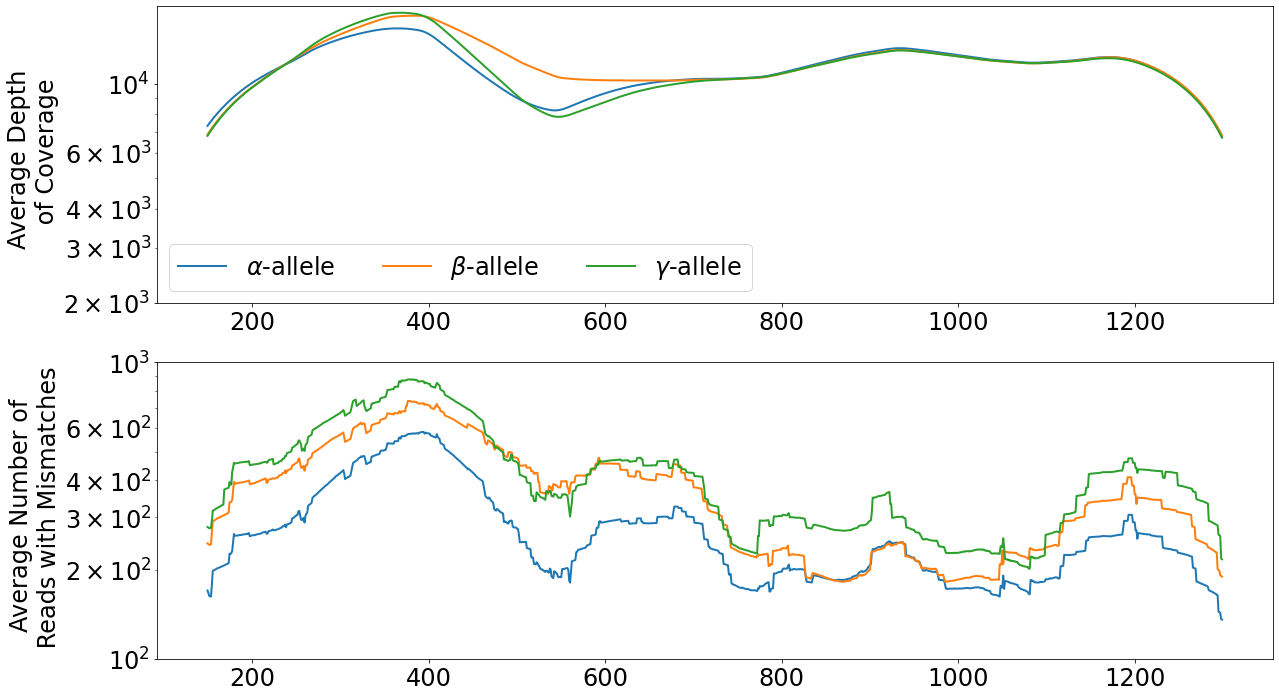

In [28]:
fig, ax = plt.subplots(2,1,figsize = (20,12))
ax[0].plot(pd.Series(op[alleles[0]]['Coverage']).rolling(window = 150).mean(), color = 'C0', 
           label = r'$\alpha$-allele', linewidth = 2)
ax[0].plot(pd.Series(op[alleles[1]]['Coverage']).rolling(window = 150).mean(), color = 'C1', 
           label = r'$\beta$-allele', linewidth = 2)
ax[0].plot(pd.Series(op[alleles[2]]['Coverage']).rolling(window = 150).mean(), color = 'C2', 
           label = r'$\gamma$-allele', linewidth = 2)

ax[1].plot(pd.Series(op[alleles[0]]['Mismatches']).rolling(window = 150).mean(), color = 'C0', linewidth = 2)
ax[1].plot(pd.Series(op[alleles[1]]['Mismatches']).rolling(window = 150).mean(), color = 'C1', linewidth = 2)
ax[1].plot(pd.Series(op[alleles[2]]['Mismatches']).rolling(window = 150).mean(), color = 'C2', linewidth = 2)

ax[0].legend(ncol = 3)
ax[0].set_ylabel('Average Depth \n of Coverage')
ax[1].set_ylabel('Average Number of \n Reads with Mismatches')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_yticks([2000, 10000])
ax[1].set_yticks([100, 1000])

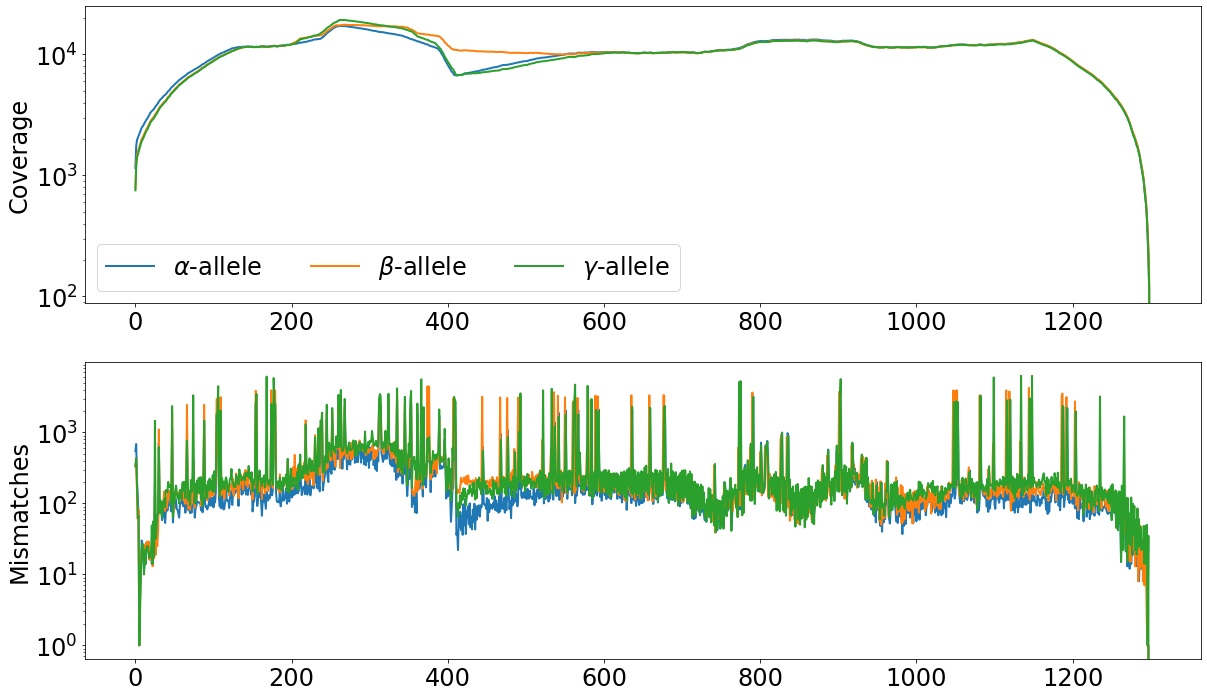

In [29]:
fig, ax = plt.subplots(2,1,figsize = (20,12))
ax[0].plot(op[alleles[0]]['Coverage'], color = 'C0', label = r'$\alpha$-allele', linewidth = 2)
ax[0].plot(op[alleles[1]]['Coverage'], color = 'C1', label = r'$\beta$-allele', linewidth = 2)
ax[0].plot(op[alleles[2]]['Coverage'], color = 'C2', label = r'$\gamma$-allele', linewidth = 2)

ax[1].plot(op[alleles[0]]['Mismatches'], color = 'C0', linewidth = 2)
ax[1].plot(op[alleles[1]]['Mismatches'], color = 'C1', linewidth = 2)
ax[1].plot(op[alleles[2]]['Mismatches'], color = 'C2', linewidth = 2)

ax[0].legend(loc = 3, ncol = 3)
ax[0].set_ylabel('Coverage')
ax[1].set_ylabel('Mismatches')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

In [30]:
df_filt_400 = df_all_abundances[(df_all_abundances['SStart'] >= 200)&(df_all_abundances['SEnd'] <= 400)]
df_filt_1200 = df_all_abundances[(df_all_abundances['SStart'] >= 1000)&(df_all_abundances['SEnd'] <= 1200)]

df_filt_400_grp = df_filt_400.groupby(['Subject','MisMatches']).apply(Coverage_Stats,slen = 1300, length = 200)
df_filt_400_grp = df_filt_400_grp.reset_index().set_index(['Subject'])
df_filt_400_grp['Divergence'] = df_filt_400_grp['MisMatches']/150.0*100

df_filt_1200_grp = df_filt_1200.groupby(['Subject','MisMatches']).apply(Coverage_Stats,slen = 1300, length = 200)
df_filt_1200_grp = df_filt_1200_grp.reset_index().set_index(['Subject'])
df_filt_1200_grp['Divergence'] = df_filt_1200_grp['MisMatches']/150.0*100


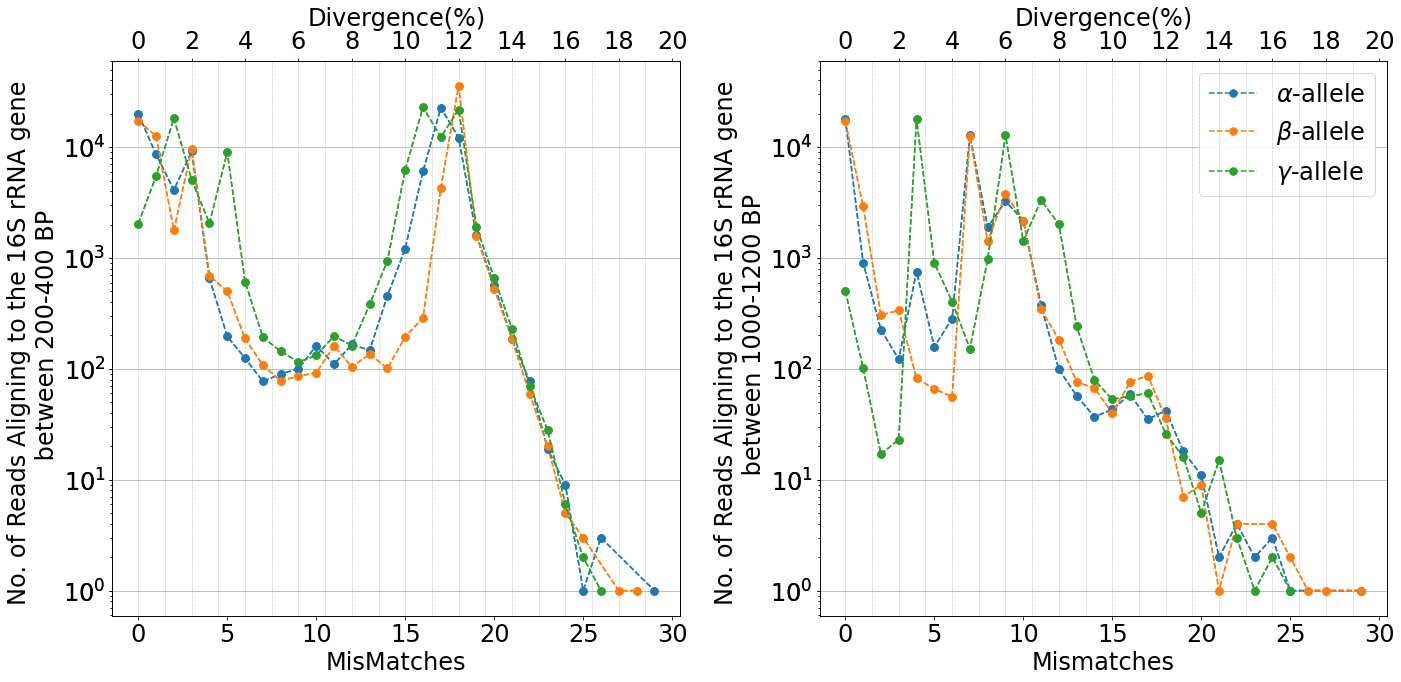

In [31]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_filt_400_grp.loc[species[i]].plot('MisMatches','Num_Reads', color = colors[i], marker = 'o', 
                                          ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_filt_400_grp.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], legend = False, 
                                          marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_filt_1200_grp.loc[species[i]].plot('MisMatches','Num_Reads', color = colors[i], marker = 'o', 
                                          ms = 7.5, ax = ax[1], linestyle = '--')
    df_filt_1200_grp.loc[species[i]].plot('Divergence','Num_Reads', color = colors[i], marker = 'o', ms = 7.5, 
                                          ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('No. of Reads Aligning to the 16S rRNA gene \n between 200-400 BP')
ax[1].set_ylabel('No. of Reads Aligning to the 16S rRNA gene \n between 1000-1200 BP')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

ax[0].yaxis.grid()
ax[1].yaxis.grid()

fig.tight_layout()

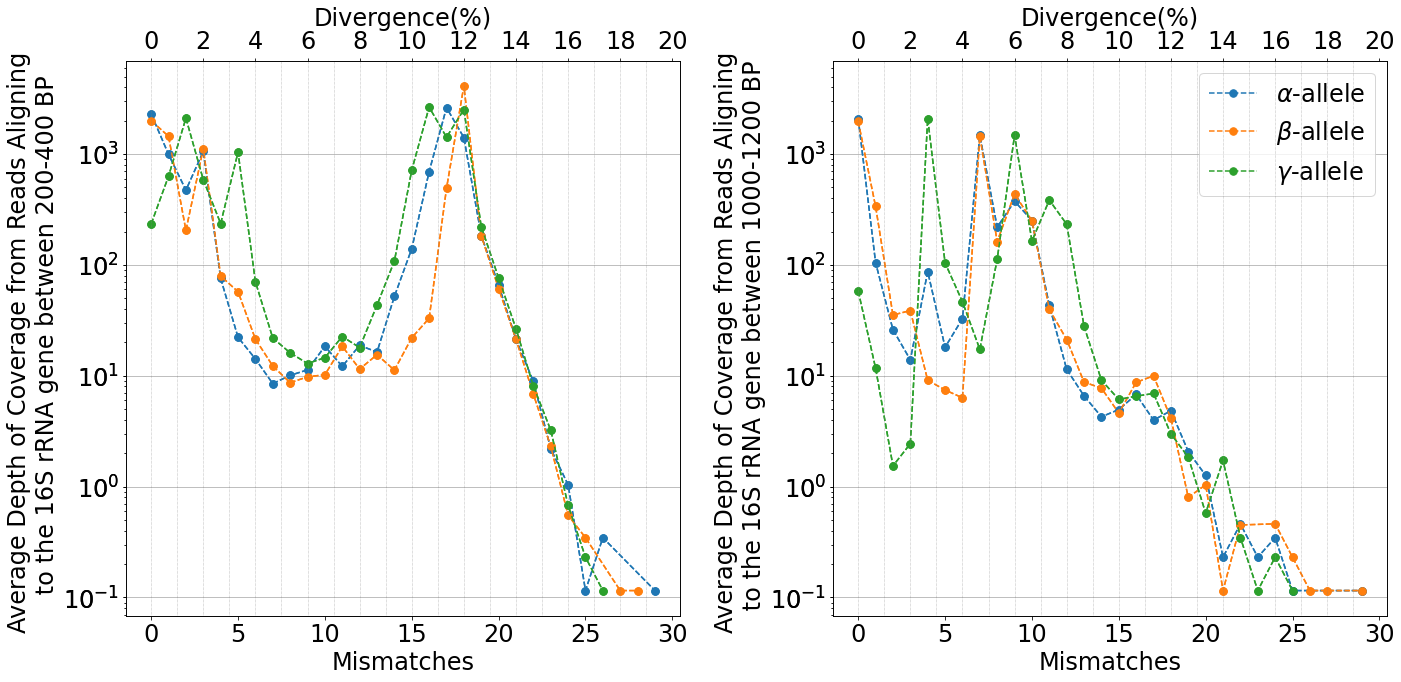

In [32]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize=(20,10))
species = ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']
colors = ['C0','C1','C2']
ax02, ax12 = ax[0].twiny(), ax[1].twiny()

for i in range(len(species)):
    df_filt_400_grp.loc[species[i]].plot('MisMatches','Avg_Depth_Coverage', color = colors[i], marker = 'o', 
                                          ms = 7.5, ax = ax[0], linestyle = '--', legend = False)
    df_filt_400_grp.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], legend = False, 
                                          marker = 'o', ms = 7.5, ax = ax02, linestyle = '--')
    df_filt_1200_grp.loc[species[i]].plot('MisMatches','Avg_Depth_Coverage', color = colors[i], marker = 'o', 
                                          ms = 7.5, ax = ax[1], linestyle = '--')
    df_filt_1200_grp.loc[species[i]].plot('Divergence','Avg_Depth_Coverage', color = colors[i], marker = 'o', ms = 7.5, 
                                          ax = ax12, linestyle = '--', legend = False)
ax[0].set_yscale('log')
ax[0].set_ylabel('Average Depth of Coverage from Reads Aligning \n to the 16S rRNA gene between 200-400 BP')
ax[1].set_ylabel('Average Depth of Coverage from Reads Aligning \n to the 16S rRNA gene between 1000-1200 BP')
ax[1].legend([r'$\alpha$-allele',r'$\beta$-allele',r'$\gamma$-allele'], ncol=1)
ax[1].set_yscale('log')
ax[0].set_xlabel('Mismatches')
ax[1].set_xlabel('Mismatches')
ax[1].set_ylim(ax[0].get_ylim())

for i in range(0, int(ax02.get_xlim()[1])):
    ax02.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax02.set_xticks(np.arange(0,int(ax02.get_xlim()[1])+1,2))
ax02.set_xlabel('Divergence(%)')

for i in range(0, int(ax12.get_xlim()[1])):
    ax12.axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
ax12.set_xticks(np.arange(0,int(ax12.get_xlim()[1])+1,2))
ax12.set_xlabel('Divergence(%)')

ax[0].yaxis.grid()
ax[1].yaxis.grid()

fig.tight_layout()

In [33]:
df_filt_400 = df_MS_all_reads[(df_MS_all_reads['SStart'] >= 200)&(df_MS_all_reads['SEnd'] <= 400)]
df_filt_1200 = df_MS_all_reads[(df_MS_all_reads['SStart'] >= 1000)&(df_MS_all_reads['SEnd'] <= 1200)]

df_filt_400_grp = df_filt_400.groupby(['Subject','Sample','MisMatches']).apply(Coverage_Stats,slen = 1300, length = 200)
df_filt_400_grp = df_filt_400_grp.reset_index().set_index(['Subject','Sample'])
df_filt_400_grp['Divergence'] = df_filt_400_grp['MisMatches']/150.0*100

df_filt_1200_grp = df_filt_1200.groupby(['Subject','Sample','MisMatches']).apply(Coverage_Stats,slen = 1300, length = 200)
df_filt_1200_grp = df_filt_1200_grp.reset_index().set_index(['Subject','Sample'])
df_filt_1200_grp['Divergence'] = df_filt_1200_grp['MisMatches']/150.0*100


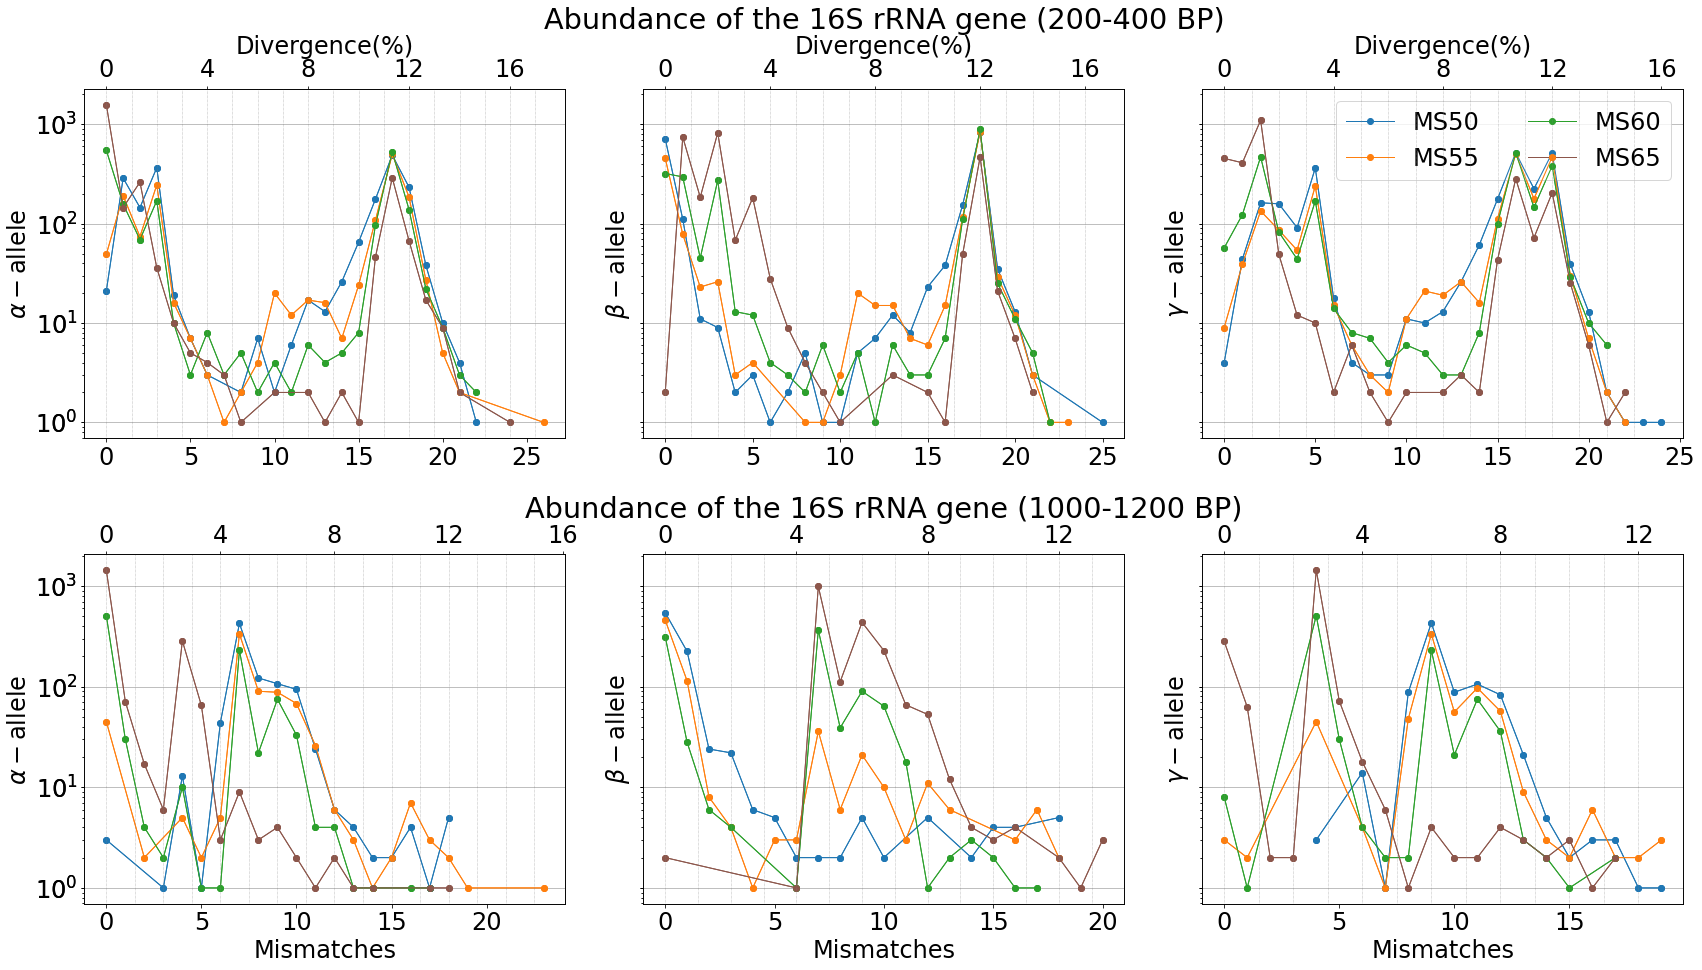

In [34]:
plt.rcParams.update(rcParams)
colors = ['C0','C1','C2','C5']

samples = df_all_abundances_grp_sample_full.reset_index()['Sample'].unique()
fig, ax = plt.subplots(2,3, figsize = (24, 14))
ax0_twinx = [ax[0][0].twiny(), ax[0][1].twiny(), ax[0][2].twiny()]
ax1_twinx = [ax[1][0].twiny(), ax[1][1].twiny(), ax[1][2].twiny()]
ylabels = [r'$\alpha-$allele',r'$\beta-$allele',r'$\gamma-$allele']
for j in range(0, len(samples_of_interest)):
    for i in range(0, len(species)):
        s = samples_of_interest[j]
        df_filt_400_grp.loc[(species[i],s)].plot('MisMatches', 'Num_Reads', marker = 'o', ax = ax[0][i], 
                                                 color = colors[j],legend = False, linewidth = 1)
        df_filt_400_grp.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', ax = ax0_twinx[i], 
                                                 color = colors[j], legend = False, linewidth = 1)
        
        df_filt_1200_grp.loc[(species[i],s)].plot('MisMatches','Num_Reads',marker = 'o', ax = ax[1][i], 
                                                  color = colors[j], legend = False, linewidth = 1) 
        df_filt_1200_grp.loc[(species[i],s)].plot('Divergence', 'Num_Reads',marker = 'o', ax = ax1_twinx[i], 
                                                  color = colors[j], legend = False, linewidth = 1) 
ax[0][2].legend(['MS50','MS55','MS60','MS65'], loc = 1, ncol = 2)

for j in range(0, len(species)):
    for i in range(0, int(ax0_twinx[j].get_xlim()[1])):
        ax0_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax0_twinx[j].set_xticks(np.arange(0,int(ax0_twinx[j].get_xlim()[1])+1,4))
    ax0_twinx[j].set_xlabel('Divergence(%)')
    ax[0][j].set_xlabel('')
    ax[0][j].set_yscale('log')
    ax[0][j].set_ylim(ax[0][0].get_ylim())
    ax[0][j].set_ylabel(ylabels[j])
    ax[0][j].yaxis.grid() 

    
    for i in range(0, int(ax1_twinx[j].get_xlim()[1])):
        ax1_twinx[j].axvline(i, linestyle = ':', color = 'grey', linewidth = 0.5)
    ax1_twinx[j].set_xticks(np.arange(0,int(ax1_twinx[j].get_xlim()[1])+1,4))
    ax1_twinx[j].set_xlabel('')
    ax[1][j].set_xlabel('Mismatches')
    ax[1][j].set_yscale('log')
    ax[1][j].set_ylim(ax[1][0].get_ylim())
    ax[1][j].set_ylabel(ylabels[j])
    ax[1][j].yaxis.grid() 
    if j != 0:
        ax[0][j].set_yticklabels([])
        ax[1][j].set_yticklabels([])
        
ax[0][1].set_title('Abundance of the 16S rRNA gene (200-400 BP)')
ax[1][1].set_title('Abundance of the 16S rRNA gene (1000-1200 BP)')

fig.tight_layout()


In [35]:
fdir = '/Users/harihara/Mount-2/hotspring_metagenome/single_cell_analysis_with_Gabe_Birzu/16S_Gene_Segments/'
out = {}
for f in ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']:
    lines = open(fdir+f+'.fna').readlines()
    s = ''
    for l in lines:
        if not l.startswith('>'):
            s += l.replace("\n","")
    out[f.replace("Synechococcus_","").replace("_16SrRNA","")] = s

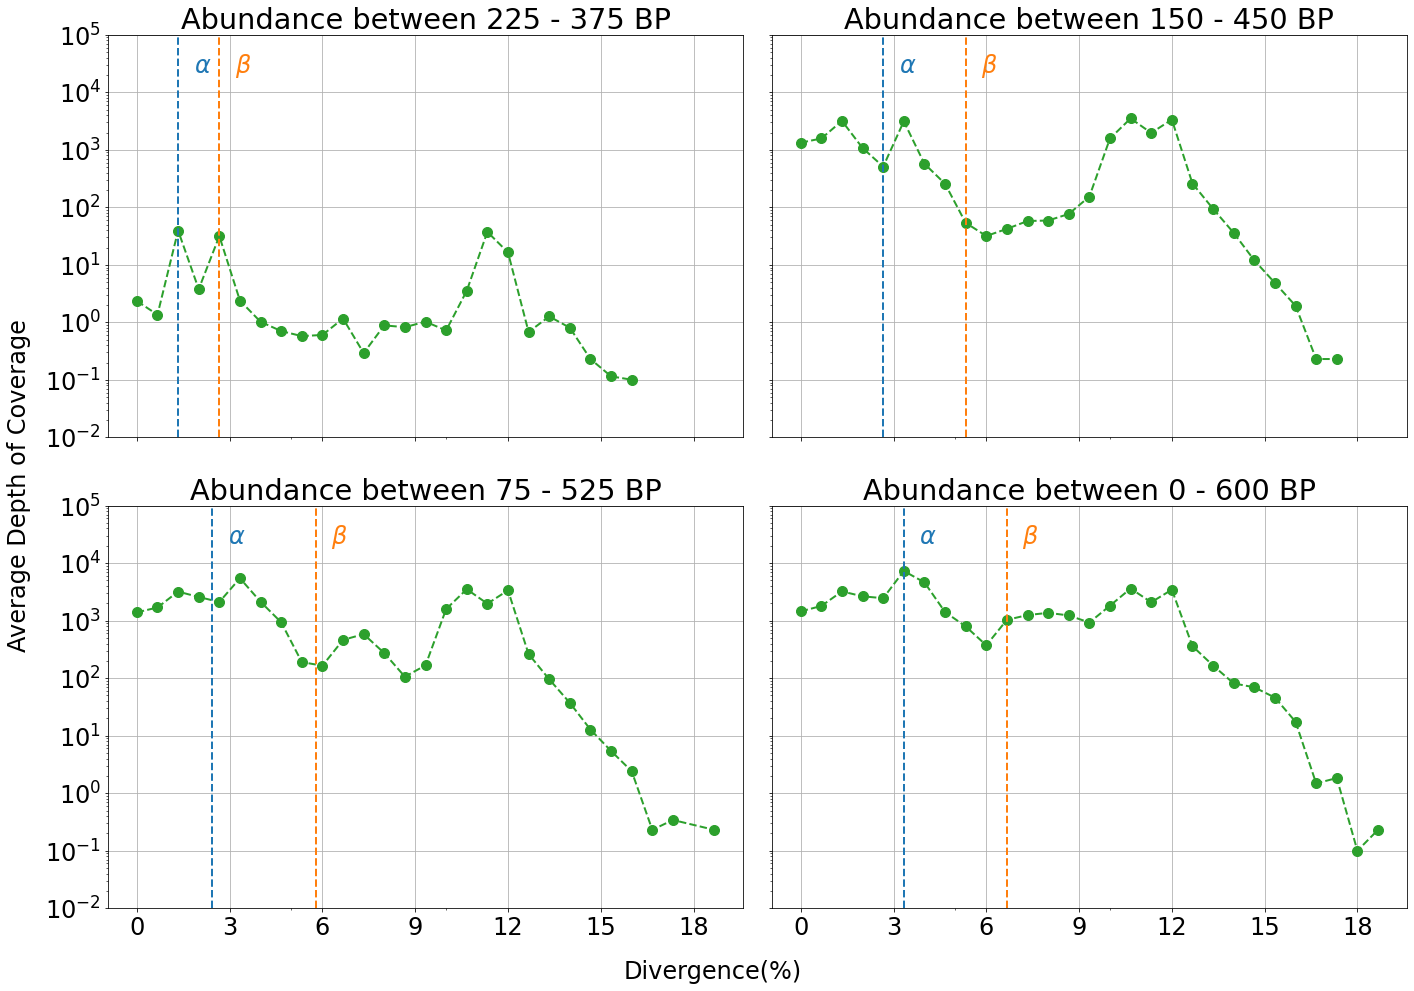

In [36]:
fig,ax = plt.subplots(2,2, figsize = (20,14), sharex = True, sharey = True)

mid = 300
exp = 75
for i in range(1, 5):
    start, end = mid - i*exp, mid + i*exp
    df_sel = df_all_abundances[(df_all_abundances['SStart'] >=start ) & (df_all_abundances['SEnd'] <=end )]
    df_grp = df_sel.groupby(['Subject','MisMatches']).apply(Coverage_Stats, slen = 1300, pe = False, 
                                                            length = end-start)
    df_grp = df_grp.reset_index().set_index('Subject')
    df_grp['Divergence'] = df_grp['MisMatches']/150*100.0
    
    alpha = out['Alpha'][start:end]
    beta = out['Beta'][start:end]
    gamma = out['Gamma'][start:end]
    mismat_alpha_gamma = Edit(alpha, gamma)/len(alpha)*100.0
    mismat_beta_gamma = Edit(beta, gamma)/len(alpha)*100.0
    m,n = (i-1)%2, int((i-1)/2)
    
    df_grp.loc['Synechococcus_Gamma_16SrRNA'].plot('Divergence','Avg_Depth_Coverage',color = 'C2',marker = 'o', 
                                                   linewidth = 2, ms = 10, ax = ax[n][m], linestyle = '--', 
                                                   legend = False)
    ax[n][m].set_title('Abundance between '+str(start)+' - '+str(end)+' BP')
    ax[n][m].axvline(mismat_alpha_gamma, color = 'C0', linewidth = 2, linestyle = '--')
    ax[n][m].axvline(mismat_beta_gamma, color = 'C1', linewidth = 2, linestyle = '--')
    ax[n][m].text(x = mismat_alpha_gamma+0.5, y = 22000, s = r'$\alpha$', c = 'C0')
    ax[n][m].text(x = mismat_beta_gamma+0.5, y = 22000, s = r'$\beta$', c = 'C1')
    
    ax[n][m].set_yticks([0.01, 0.1, 1, 10, 100, 1000, 10000, 100000])
    ax[n][m].set_ylim([0.01, 100000])
    ax[n][m].set_xticks(np.arange(0,21,3))    
    
    ax[n][m].set_xlabel('')
    ax[n][m].set_yscale('log')
    ax[n][m].grid()
fig.text(0.5, 0.01, 'Divergence(%)', ha='center')
fig.text(0.01, 0.5, 'Average Depth of Coverage', va='center', rotation = 'vertical')
fig.tight_layout()
fig.subplots_adjust(left = 0.08, bottom = 0.08)